In [1]:
import rioxarray as rxr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
import fiona
import pyproj
#import contextily as ctx
import os
import requests
import matplotlib.ticker as ticker
from rasterio.enums import Resampling
from affine import Affine
import shapely.geometry
import pyproj
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from itertools import combinations

from catboost import CatBoostRegressor
import seaborn as sns

/Users/amandaworthy/opt/anaconda3/envs/uwgda2022/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


Grid grid_gdf for 
- 'streets_length_370',
    - Done
- 'avg_canopy_970'
    - IP
- 'mode_landcover_70'
- 'building_count_580',
    - Done 
- 'building_area_940'
    - IP
- 'water_area_730'
    - IP
- 'avg_lst_520'

In [2]:
!pwd

/Users/amandaworthy/Paper3_map_generation


In [3]:
!ls

1_create_map_and_buffers_sample_at_sensors.ipynb
2_best_buffer_size.ipynb
3_gridding_and_modeling.ipynb
README.md
TMYx_ENG_dataset_with_optimal_buffer_lengths_for_prediction.csv
buffered_jan22_some_attributes.csv
buffered_jan22_some_attributesb4lst.csv
buffered_jan29_some_attributes.csv
buffered_jan29_some_attributes_rn.csv
buffered_jan29_some_attributesb4lst.csv


In [4]:
data_fxn = '/Users/amandaworthy/Paper3_map_generation/TMYx_ENG_dataset_with_optimal_buffer_lengths_for_prediction.csv'

df = pd.read_csv(data_fxn)

df

mygeometry_array = gpd.points_from_xy(df['Longitude (E+/W-)'], df['Latitude (N+/S-)'])

gdf= gpd.GeoDataFrame(
    df, crs='EPSG:3395', geometry=mygeometry_array)

gdf.head()

,WMO,Latitude (N+/S-),Longitude (E+/W-),Elevation (m),geometry,Total Energy [kBtu],streets_length_370,avg_canopy_970,mode_landcover_70,building_count_580,building_area_940,water_area_730,avg_lst_520
0,727930,47.44400,-122.3140,137.0,POINT (-122.314 47.444),51530.00,730.856526,2.044056,0.0,0,5.934253e-07,0.000000,36.696189
1,727939,47.57627,-122.4206,1.0,POINT (-122.421 47.576),50224.89,860.999766,2.092685,23.0,114,6.513970e-06,0.000072,17.799480
2,746938,47.68619,-122.2605,18.3,POINT (-122.26 47.686),51919.64,1845.552206,7.102628,24.0,20,1.546807e-05,0.000021,33.133572
3,727934,47.49300,-122.2140,10.0,POINT (-122.214 47.493),50074.66,1946.227989,6.973427,24.0,25,1.507119e-05,0.000004,35.087714
4,994014,47.60500,-122.3380,2.0,POINT (-122.338 47.605),48629.95,7529.461982,0.769231,24.0,46,4.187399e-05,0.000029,29.271105


In [5]:
from operator import itemgetter
import datetime as dt
# get the bounds of the seattle city limits 
start = dt.datetime.now()

bounds = gdf.geometry.apply(lambda x: x.bounds).tolist()

minx, miny, maxx, maxy = min(bounds, key=itemgetter(0))[0], min(bounds, key=itemgetter(1))[1], max(bounds, key=itemgetter(2))[2], max(bounds, key=itemgetter(3))[3] #https://stackoverflow.com/questions/13145368/find-the-maximum-value-in-a-list-of-tuples-in-python
print(minx, miny, maxx, maxy)

-122.4353 47.444 -122.214 47.68619


In [6]:
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer

def create_grid(minx, miny, maxx, maxy, grid_size):
    grid_cells = []
    x_range = range(int(minx-0.1), int(maxx+0.1), grid_size)
    y_range = range(int(miny-0.1), int(maxy+0.1), grid_size)
    
    for x in x_range:
        for y in y_range:
            grid_cells.append(Polygon([(x, y), (x + grid_size, y), (x + grid_size, y + grid_size), (x, y + grid_size)]))
    
    grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='EPSG:3857')
    return grid

# Define the bounding box in geographic coordinates (longitude, latitude)
minx, miny, maxx, maxy = -122.43595589761995, 47.495513623976045, -122.23604445458422, 47.734164946845

# Create a transformer to convert from EPSG:4326 to EPSG:3857
transformer = Transformer.from_crs(CRS("EPSG:4326"), CRS("EPSG:3857"), always_xy=True)

# Transform the bounding box coordinates to EPSG:3857
minx_proj, miny_proj = transformer.transform(minx, miny)
maxx_proj, maxy_proj = transformer.transform(maxx, maxy)

# Grid size of 2000 meters
grid_size = 500 #can change

# Create the grid
grid_gdf = create_grid(minx_proj, miny_proj, maxx_proj, maxy_proj, grid_size)

# Optionally, convert the grid back to the original CRS
grid_gdf = grid_gdf.to_crs(epsg=4326)

# Extract bounds (minx, miny, maxx, maxy) for each grid cell and add them as columns
grid_gdf['min_lon'] = grid_gdf['geometry'].bounds.minx
grid_gdf['min_lat'] = grid_gdf['geometry'].bounds.miny
grid_gdf['max_lon'] = grid_gdf['geometry'].bounds.maxx
grid_gdf['max_lat'] = grid_gdf['geometry'].bounds.maxy

grid_gdf

,geometry,min_lon,min_lat,max_lon,max_lat
0,"POLYGON ((-122.43595 47.49551, -122.43146 47.4...",-122.435954,47.495508,-122.431462,47.498543
1,"POLYGON ((-122.43595 47.49854, -122.43146 47.4...",-122.435954,47.498543,-122.431462,47.501577
2,"POLYGON ((-122.43595 47.50158, -122.43146 47.5...",-122.435954,47.501577,-122.431462,47.504611
3,"POLYGON ((-122.43595 47.50461, -122.43146 47.5...",-122.435954,47.504611,-122.431462,47.507646
4,"POLYGON ((-122.43595 47.50765, -122.43146 47.5...",-122.435954,47.507646,-122.431462,47.510680
...,...,...,...,...,...
3550,"POLYGON ((-122.23832 47.7196, -122.23383 47.71...",-122.238324,47.719598,-122.233833,47.722619
3551,"POLYGON ((-122.23832 47.72262, -122.23383 47.7...",-122.238324,47.722619,-122.233833,47.725641
3552,"POLYGON ((-122.23832 47.72564, -122.23383 47.7...",-122.238324,47.725641,-122.233833,47.728662
3553,"POLYGON ((-122.23832 47.72866, -122.23383 47.7...",-122.238324,47.728662,-122.233833,47.731683


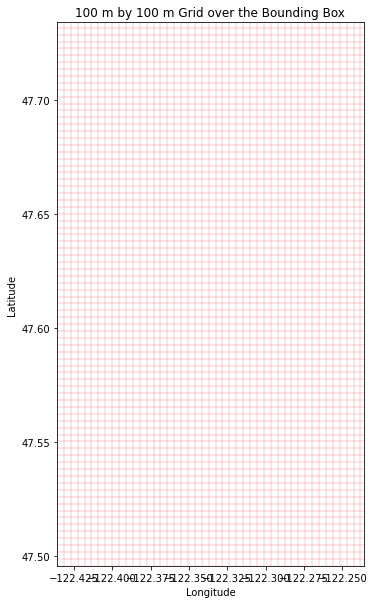

In [7]:
# Plot the grid
fig, ax = plt.subplots(figsize=(10, 10))
grid_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.1)
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("100 m by 100 m Grid over the Bounding Box")
#plt.title("100m by 100m Grid over the Bounding Box")
plt.show()

In [8]:
gdf.columns

Index(['WMO', 'Latitude (N+/S-)', 'Longitude (E+/W-)', 'Elevation (m)',
       'geometry', 'Total Energy [kBtu]', 'streets_length_370',
       'avg_canopy_970', 'mode_landcover_70', 'building_count_580',
       'building_area_940', 'water_area_730', 'avg_lst_520'],
      dtype='object')

In [9]:
gdf

,WMO,Latitude (N+/S-),Longitude (E+/W-),Elevation (m),geometry,Total Energy [kBtu],streets_length_370,avg_canopy_970,mode_landcover_70,building_count_580,building_area_940,water_area_730,avg_lst_520
0,727930,47.44400,-122.3140,137.0,POINT (-122.314 47.444),51530.00,730.856526,2.044056,0.0,0,5.934253e-07,0.000000,36.696189
1,727939,47.57627,-122.4206,1.0,POINT (-122.421 47.576),50224.89,860.999766,2.092685,23.0,114,6.513970e-06,0.000072,17.799480
2,746938,47.68619,-122.2605,18.3,POINT (-122.26 47.686),51919.64,1845.552206,7.102628,24.0,20,1.546807e-05,0.000021,33.133572
3,727934,47.49300,-122.2140,10.0,POINT (-122.214 47.493),50074.66,1946.227989,6.973427,24.0,25,1.507119e-05,0.000004,35.087714
4,994014,47.60500,-122.3380,2.0,POINT (-122.338 47.605),48629.95,7529.461982,0.769231,24.0,46,4.187399e-05,0.000029,29.271105
5,994350,47.66200,-122.4353,3.0,POINT (-122.435 47.662),49613.79,188.386766,2.894056,31.0,6,2.319276e-06,0.000077,17.161170
6,727935,47.53000,-122.3010,6.0,POINT (-122.301 47.53),50751.23,0.000000,2.687855,23.0,13,1.178035e-05,0.000000,37.318259


In [ ]:
# Plot the GeoDataFrame
gdf.plot(column='Total Energy [kBtu]', marker='o', cmap='Greens', 
         legend=True, markersize=90, figsize=(10, 6))

In [10]:
features = ['Elevation (m)', 'streets_length_370',
       'avg_canopy_970', 'mode_landcover_70', 'building_count_580',
       'building_area_940', 'water_area_730', 'avg_lst_520' ]


target = 'Total Energy [kBtu]'

gdf = gdf.dropna(subset=features + [target])

X= gdf[features]
y= gdf[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=21)



# Output shapes for verification
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")



X_train shape: (6, 8)
X_test shape: (1, 8)
y_train shape: (6,)
y_test shape: (1,)


In [11]:
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor(n_estimators=100, random_state=42)
RF_model.fit(X_train, y_train)

# Make predictions
y_train_pred = RF_model.predict(X_train)
y_test_pred = RF_model.predict(X_test)

# Calculate RMSE and R² for the training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Calculate RMSE and R² for the testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Report the results
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training R²: {train_r2:.2f}")
print(f"Testing R²: {test_r2:.2f}")

Training RMSE: 448.54
Testing RMSE: 477.78
Training R²: 0.84
Testing R²: nan


/Users/amandaworthy/opt/anaconda3/envs/uwgda2022/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


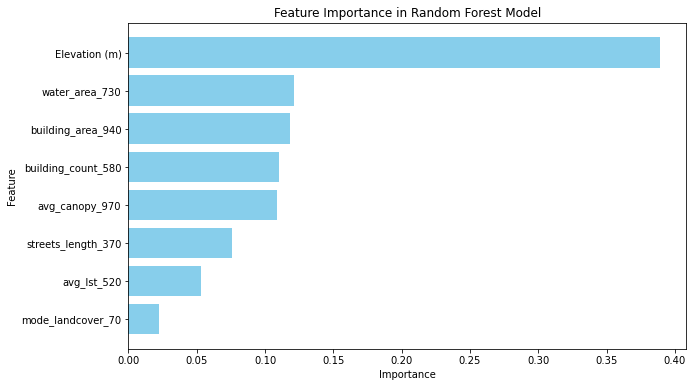

In [12]:
# Extract feature importances
importances = RF_model.feature_importances_
features= RF_model.feature_names_in_

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

In [13]:
# Create a new GeoDataFrame with midpoints (centroids)
midpoint_gdf = grid_gdf.copy()

midpoint_gdf = midpoint_gdf.to_crs(epsg=3857)
midpoint_gdf['geometry'] = grid_gdf['geometry'].centroid

# record min lon and lat 
midpoint_gdf['min_lon'] = grid_gdf['geometry'].bounds.minx
midpoint_gdf['min_lat'] = grid_gdf['geometry'].bounds.miny
midpoint_gdf['max_lon'] = grid_gdf['geometry'].bounds.maxx
midpoint_gdf['max_lat'] = grid_gdf['geometry'].bounds.maxy

# Optionally, convert the midpoint GeoDataFrame back to EPSG:4326
midpoint_gdf = midpoint_gdf.to_crs(epsg=4326)

/var/folders/_0/wy7tb6qj0kn08q2vk43vjwb40000gn/T/ipykernel_2036/3310807913.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  midpoint_gdf['geometry'] = grid_gdf['geometry'].centroid


In [14]:
midpoint_gdf

,geometry,min_lon,min_lat,max_lon,max_lat
0,POINT (-122.43371 47.49703),-122.435954,47.495508,-122.431462,47.498543
1,POINT (-122.43371 47.50006),-122.435954,47.498543,-122.431462,47.501577
2,POINT (-122.43371 47.50309),-122.435954,47.501577,-122.431462,47.504611
3,POINT (-122.43371 47.50613),-122.435954,47.504611,-122.431462,47.507646
4,POINT (-122.43371 47.50916),-122.435954,47.507646,-122.431462,47.510680
...,...,...,...,...,...
3550,POINT (-122.23608 47.72111),-122.238324,47.719598,-122.233833,47.722619
3551,POINT (-122.23608 47.72413),-122.238324,47.722619,-122.233833,47.725641
3552,POINT (-122.23608 47.72715),-122.238324,47.725641,-122.233833,47.728662
3553,POINT (-122.23608 47.73017),-122.238324,47.728662,-122.233833,47.731683


In [15]:
# define a dataset with buffer lengths ranging from 100 to 5000 m in 100 meter increments 
# save these buffer lengths in a dictionary to call for creating each buffer length 
# make a dictionary of the needed buffer length and varraible attributes 
    
# Define buffer distances
buffer_distances = range(10, 1000, 30)

# Initialize dictionary to hold buffers GeoDataFrames by distance
buffers_dict = {}

midpoint_gdf = midpoint_gdf.to_crs(epsg=3857)

# Iterate over each buffer distance and create a buffer GeoDataFrame
for distance in buffer_distances:
    # Create a new GeoDataFrame with buffered geometries at the current distance
    buffer_gdf = midpoint_gdf.copy()
    buffer_gdf['geometry'] = buffer_gdf['geometry'].buffer(distance)
    buffer_gdf['buffer_size'] = distance  # Add buffer_size column
    
    # Add the buffered GeoDataFrame to the dictionary with the distance as the key
    buffers_dict[distance] = buffer_gdf

<AxesSubplot:>

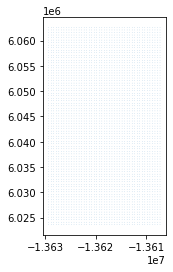

In [17]:
# example for how to access 

buffers_dict[40].plot()

In [18]:
gdf.columns

Index(['WMO', 'Latitude (N+/S-)', 'Longitude (E+/W-)', 'Elevation (m)',
       'geometry', 'Total Energy [kBtu]', 'streets_length_370',
       'avg_canopy_970', 'mode_landcover_70', 'building_count_580',
       'building_area_940', 'water_area_730', 'avg_lst_520'],
      dtype='object')

## streets_length_370

In [19]:
streets_fn = '/Users/amandaworthy/PHI_Big_Files/Metro_Transportation_Network_(TNET)_in_King_County_for_Car_Mode___trans_network_car_line.geojson'

streets = gpd.read_file(streets_fn, crs='EPSG:4326')

streets = streets.to_crs('EPSG:3395')

streets.crs

/Users/amandaworthy/opt/anaconda3/envs/uwgda2022/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(


<Derived Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 80°S and 84°N.
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
streets = streets.to_crs(epsg=3857)
grid_gdf = grid_gdf.to_crs(epsg=3857)

<AxesSubplot:>

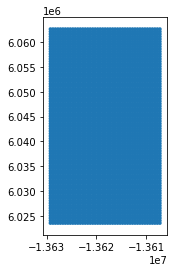

In [21]:
grid_gdf_370= buffers_dict[370]

grid_gdf_370 = grid_gdf_370.to_crs(epsg=3857)
grid_gdf = grid_gdf.to_crs(epsg=3857)

grid_gdf_370.plot()

In [26]:
import geopandas as gpd
from shapely.ops import unary_union
import time

# Start timing
start_time = time.time()

# Combine the streets into a union
combined_lines = streets.geometry.unary_union
streets_combined = gpd.GeoDataFrame(geometry=[combined_lines], crs=streets.crs)

# Calculate intersections in all rows
intersections = []
total_rows = len(grid_gdf_370)  # Total number of rows in the test GeoDataFrame

# Iterate over each row in the `test` GeoDataFrame
for idx, row in grid_gdf_370.iterrows():
    # Calculate the intersection of the buffer with the streets_combined
    intersection = streets_combined.intersection(row['geometry'])
    intersection = unary_union(intersection)
    intersections.append(intersection)
    
    # Calculate and print percentage completion
    percent_complete = (idx + 1) / total_rows * 100
    elapsed_time = time.time() - start_time
    print(f"Progress: {percent_complete:.2f}% complete. Elapsed time: {elapsed_time:.2f} seconds.")

# Create a GeoDataFrame with the results
result = gpd.GeoDataFrame({'geometry': intersections}, crs=grid_gdf_370.crs)


# Add the intersections and lengths to the original `test` GeoDataFrame
grid_gdf['streets_length_370'] = result['geometry'].length


# Print the total time taken
total_time = time.time() - start_time
print(f"Total time taken: {total_time:.2f} seconds.")


/var/folders/_0/wy7tb6qj0kn08q2vk43vjwb40000gn/T/ipykernel_2036/1847549492.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_lines = streets.geometry.unary_union


Progress: 0.03% complete. Elapsed time: 1.41 seconds.
Progress: 0.06% complete. Elapsed time: 1.42 seconds.
Progress: 0.08% complete. Elapsed time: 1.42 seconds.
Progress: 0.11% complete. Elapsed time: 1.43 seconds.
Progress: 0.14% complete. Elapsed time: 1.43 seconds.
Progress: 0.17% complete. Elapsed time: 1.44 seconds.
Progress: 0.20% complete. Elapsed time: 1.45 seconds.
Progress: 0.23% complete. Elapsed time: 1.45 seconds.
Progress: 0.25% complete. Elapsed time: 1.46 seconds.
Progress: 0.28% complete. Elapsed time: 1.46 seconds.
Progress: 0.31% complete. Elapsed time: 1.47 seconds.
Progress: 0.34% complete. Elapsed time: 1.47 seconds.
Progress: 0.37% complete. Elapsed time: 1.48 seconds.
Progress: 0.39% complete. Elapsed time: 1.49 seconds.
Progress: 0.42% complete. Elapsed time: 1.49 seconds.
Progress: 0.45% complete. Elapsed time: 1.50 seconds.
Progress: 0.48% complete. Elapsed time: 1.50 seconds.
Progress: 0.51% complete. Elapsed time: 1.51 seconds.
Progress: 0.53% complete. El

Progress: 4.92% complete. Elapsed time: 2.43 seconds.
Progress: 4.95% complete. Elapsed time: 2.44 seconds.
Progress: 4.98% complete. Elapsed time: 2.44 seconds.
Progress: 5.01% complete. Elapsed time: 2.45 seconds.
Progress: 5.04% complete. Elapsed time: 2.46 seconds.
Progress: 5.06% complete. Elapsed time: 2.46 seconds.
Progress: 5.09% complete. Elapsed time: 2.47 seconds.
Progress: 5.12% complete. Elapsed time: 2.47 seconds.
Progress: 5.15% complete. Elapsed time: 2.48 seconds.
Progress: 5.18% complete. Elapsed time: 2.48 seconds.
Progress: 5.20% complete. Elapsed time: 2.49 seconds.
Progress: 5.23% complete. Elapsed time: 2.50 seconds.
Progress: 5.26% complete. Elapsed time: 2.50 seconds.
Progress: 5.29% complete. Elapsed time: 2.51 seconds.
Progress: 5.32% complete. Elapsed time: 2.51 seconds.
Progress: 5.34% complete. Elapsed time: 2.52 seconds.
Progress: 5.37% complete. Elapsed time: 2.52 seconds.
Progress: 5.40% complete. Elapsed time: 2.53 seconds.
Progress: 5.43% complete. El

Progress: 9.82% complete. Elapsed time: 3.44 seconds.
Progress: 9.85% complete. Elapsed time: 3.45 seconds.
Progress: 9.87% complete. Elapsed time: 3.45 seconds.
Progress: 9.90% complete. Elapsed time: 3.46 seconds.
Progress: 9.93% complete. Elapsed time: 3.47 seconds.
Progress: 9.96% complete. Elapsed time: 3.47 seconds.
Progress: 9.99% complete. Elapsed time: 3.48 seconds.
Progress: 10.01% complete. Elapsed time: 3.48 seconds.
Progress: 10.04% complete. Elapsed time: 3.49 seconds.
Progress: 10.07% complete. Elapsed time: 3.50 seconds.
Progress: 10.10% complete. Elapsed time: 3.50 seconds.
Progress: 10.13% complete. Elapsed time: 3.51 seconds.
Progress: 10.15% complete. Elapsed time: 3.51 seconds.
Progress: 10.18% complete. Elapsed time: 3.52 seconds.
Progress: 10.21% complete. Elapsed time: 3.53 seconds.
Progress: 10.24% complete. Elapsed time: 3.53 seconds.
Progress: 10.27% complete. Elapsed time: 3.54 seconds.
Progress: 10.30% complete. Elapsed time: 3.54 seconds.
Progress: 10.32% 

Progress: 14.54% complete. Elapsed time: 4.46 seconds.
Progress: 14.57% complete. Elapsed time: 4.47 seconds.
Progress: 14.60% complete. Elapsed time: 4.47 seconds.
Progress: 14.63% complete. Elapsed time: 4.48 seconds.
Progress: 14.66% complete. Elapsed time: 4.49 seconds.
Progress: 14.68% complete. Elapsed time: 4.49 seconds.
Progress: 14.71% complete. Elapsed time: 4.50 seconds.
Progress: 14.74% complete. Elapsed time: 4.51 seconds.
Progress: 14.77% complete. Elapsed time: 4.51 seconds.
Progress: 14.80% complete. Elapsed time: 4.52 seconds.
Progress: 14.82% complete. Elapsed time: 4.53 seconds.
Progress: 14.85% complete. Elapsed time: 4.53 seconds.
Progress: 14.88% complete. Elapsed time: 4.54 seconds.
Progress: 14.91% complete. Elapsed time: 4.54 seconds.
Progress: 14.94% complete. Elapsed time: 4.55 seconds.
Progress: 14.96% complete. Elapsed time: 4.56 seconds.
Progress: 14.99% complete. Elapsed time: 4.56 seconds.
Progress: 15.02% complete. Elapsed time: 4.57 seconds.
Progress: 

Progress: 19.30% complete. Elapsed time: 5.48 seconds.
Progress: 19.32% complete. Elapsed time: 5.49 seconds.
Progress: 19.35% complete. Elapsed time: 5.50 seconds.
Progress: 19.38% complete. Elapsed time: 5.50 seconds.
Progress: 19.41% complete. Elapsed time: 5.51 seconds.
Progress: 19.44% complete. Elapsed time: 5.52 seconds.
Progress: 19.47% complete. Elapsed time: 5.52 seconds.
Progress: 19.49% complete. Elapsed time: 5.53 seconds.
Progress: 19.52% complete. Elapsed time: 5.54 seconds.
Progress: 19.55% complete. Elapsed time: 5.54 seconds.
Progress: 19.58% complete. Elapsed time: 5.55 seconds.
Progress: 19.61% complete. Elapsed time: 5.55 seconds.
Progress: 19.63% complete. Elapsed time: 5.56 seconds.
Progress: 19.66% complete. Elapsed time: 5.57 seconds.
Progress: 19.69% complete. Elapsed time: 5.57 seconds.
Progress: 19.72% complete. Elapsed time: 5.58 seconds.
Progress: 19.75% complete. Elapsed time: 5.58 seconds.
Progress: 19.77% complete. Elapsed time: 5.59 seconds.
Progress: 

Progress: 23.85% complete. Elapsed time: 6.51 seconds.
Progress: 23.88% complete. Elapsed time: 6.51 seconds.
Progress: 23.91% complete. Elapsed time: 6.52 seconds.
Progress: 23.94% complete. Elapsed time: 6.53 seconds.
Progress: 23.97% complete. Elapsed time: 6.53 seconds.
Progress: 23.99% complete. Elapsed time: 6.54 seconds.
Progress: 24.02% complete. Elapsed time: 6.55 seconds.
Progress: 24.05% complete. Elapsed time: 6.55 seconds.
Progress: 24.08% complete. Elapsed time: 6.56 seconds.
Progress: 24.11% complete. Elapsed time: 6.57 seconds.
Progress: 24.14% complete. Elapsed time: 6.57 seconds.
Progress: 24.16% complete. Elapsed time: 6.58 seconds.
Progress: 24.19% complete. Elapsed time: 6.58 seconds.
Progress: 24.22% complete. Elapsed time: 6.59 seconds.
Progress: 24.25% complete. Elapsed time: 6.60 seconds.
Progress: 24.28% complete. Elapsed time: 6.60 seconds.
Progress: 24.30% complete. Elapsed time: 6.61 seconds.
Progress: 24.33% complete. Elapsed time: 6.61 seconds.
Progress: 

Progress: 28.41% complete. Elapsed time: 7.52 seconds.
Progress: 28.44% complete. Elapsed time: 7.53 seconds.
Progress: 28.47% complete. Elapsed time: 7.54 seconds.
Progress: 28.50% complete. Elapsed time: 7.54 seconds.
Progress: 28.52% complete. Elapsed time: 7.55 seconds.
Progress: 28.55% complete. Elapsed time: 7.55 seconds.
Progress: 28.58% complete. Elapsed time: 7.56 seconds.
Progress: 28.61% complete. Elapsed time: 7.57 seconds.
Progress: 28.64% complete. Elapsed time: 7.57 seconds.
Progress: 28.66% complete. Elapsed time: 7.58 seconds.
Progress: 28.69% complete. Elapsed time: 7.59 seconds.
Progress: 28.72% complete. Elapsed time: 7.59 seconds.
Progress: 28.75% complete. Elapsed time: 7.60 seconds.
Progress: 28.78% complete. Elapsed time: 7.60 seconds.
Progress: 28.80% complete. Elapsed time: 7.61 seconds.
Progress: 28.83% complete. Elapsed time: 7.61 seconds.
Progress: 28.86% complete. Elapsed time: 7.62 seconds.
Progress: 28.89% complete. Elapsed time: 7.63 seconds.
Progress: 

Progress: 32.88% complete. Elapsed time: 8.54 seconds.
Progress: 32.91% complete. Elapsed time: 8.55 seconds.
Progress: 32.94% complete. Elapsed time: 8.55 seconds.
Progress: 32.97% complete. Elapsed time: 8.56 seconds.
Progress: 33.00% complete. Elapsed time: 8.57 seconds.
Progress: 33.02% complete. Elapsed time: 8.57 seconds.
Progress: 33.05% complete. Elapsed time: 8.58 seconds.
Progress: 33.08% complete. Elapsed time: 8.59 seconds.
Progress: 33.11% complete. Elapsed time: 8.59 seconds.
Progress: 33.14% complete. Elapsed time: 8.60 seconds.
Progress: 33.16% complete. Elapsed time: 8.61 seconds.
Progress: 33.19% complete. Elapsed time: 8.61 seconds.
Progress: 33.22% complete. Elapsed time: 8.62 seconds.
Progress: 33.25% complete. Elapsed time: 8.63 seconds.
Progress: 33.28% complete. Elapsed time: 8.63 seconds.
Progress: 33.31% complete. Elapsed time: 8.64 seconds.
Progress: 33.33% complete. Elapsed time: 8.64 seconds.
Progress: 33.36% complete. Elapsed time: 8.65 seconds.
Progress: 

Progress: 37.27% complete. Elapsed time: 9.56 seconds.
Progress: 37.30% complete. Elapsed time: 9.57 seconds.
Progress: 37.33% complete. Elapsed time: 9.58 seconds.
Progress: 37.36% complete. Elapsed time: 9.58 seconds.
Progress: 37.38% complete. Elapsed time: 9.59 seconds.
Progress: 37.41% complete. Elapsed time: 9.60 seconds.
Progress: 37.44% complete. Elapsed time: 9.60 seconds.
Progress: 37.47% complete. Elapsed time: 9.61 seconds.
Progress: 37.50% complete. Elapsed time: 9.62 seconds.
Progress: 37.52% complete. Elapsed time: 9.62 seconds.
Progress: 37.55% complete. Elapsed time: 9.63 seconds.
Progress: 37.58% complete. Elapsed time: 9.63 seconds.
Progress: 37.61% complete. Elapsed time: 9.64 seconds.
Progress: 37.64% complete. Elapsed time: 9.65 seconds.
Progress: 37.67% complete. Elapsed time: 9.65 seconds.
Progress: 37.69% complete. Elapsed time: 9.66 seconds.
Progress: 37.72% complete. Elapsed time: 9.67 seconds.
Progress: 37.75% complete. Elapsed time: 9.67 seconds.
Progress: 

Progress: 41.63% complete. Elapsed time: 10.58 seconds.
Progress: 41.66% complete. Elapsed time: 10.59 seconds.
Progress: 41.69% complete. Elapsed time: 10.60 seconds.
Progress: 41.72% complete. Elapsed time: 10.60 seconds.
Progress: 41.74% complete. Elapsed time: 10.61 seconds.
Progress: 41.77% complete. Elapsed time: 10.62 seconds.
Progress: 41.80% complete. Elapsed time: 10.62 seconds.
Progress: 41.83% complete. Elapsed time: 10.63 seconds.
Progress: 41.86% complete. Elapsed time: 10.64 seconds.
Progress: 41.88% complete. Elapsed time: 10.64 seconds.
Progress: 41.91% complete. Elapsed time: 10.65 seconds.
Progress: 41.94% complete. Elapsed time: 10.66 seconds.
Progress: 41.97% complete. Elapsed time: 10.66 seconds.
Progress: 42.00% complete. Elapsed time: 10.67 seconds.
Progress: 42.03% complete. Elapsed time: 10.68 seconds.
Progress: 42.05% complete. Elapsed time: 10.68 seconds.
Progress: 42.08% complete. Elapsed time: 10.69 seconds.
Progress: 42.11% complete. Elapsed time: 10.70 s

Progress: 45.94% complete. Elapsed time: 11.61 seconds.
Progress: 45.96% complete. Elapsed time: 11.61 seconds.
Progress: 45.99% complete. Elapsed time: 11.62 seconds.
Progress: 46.02% complete. Elapsed time: 11.63 seconds.
Progress: 46.05% complete. Elapsed time: 11.64 seconds.
Progress: 46.08% complete. Elapsed time: 11.64 seconds.
Progress: 46.10% complete. Elapsed time: 11.65 seconds.
Progress: 46.13% complete. Elapsed time: 11.66 seconds.
Progress: 46.16% complete. Elapsed time: 11.66 seconds.
Progress: 46.19% complete. Elapsed time: 11.67 seconds.
Progress: 46.22% complete. Elapsed time: 11.68 seconds.
Progress: 46.24% complete. Elapsed time: 11.68 seconds.
Progress: 46.27% complete. Elapsed time: 11.69 seconds.
Progress: 46.30% complete. Elapsed time: 11.70 seconds.
Progress: 46.33% complete. Elapsed time: 11.70 seconds.
Progress: 46.36% complete. Elapsed time: 11.71 seconds.
Progress: 46.39% complete. Elapsed time: 11.72 seconds.
Progress: 46.41% complete. Elapsed time: 11.72 s

Progress: 50.18% complete. Elapsed time: 12.62 seconds.
Progress: 50.21% complete. Elapsed time: 12.63 seconds.
Progress: 50.24% complete. Elapsed time: 12.63 seconds.
Progress: 50.27% complete. Elapsed time: 12.64 seconds.
Progress: 50.30% complete. Elapsed time: 12.64 seconds.
Progress: 50.32% complete. Elapsed time: 12.65 seconds.
Progress: 50.35% complete. Elapsed time: 12.66 seconds.
Progress: 50.38% complete. Elapsed time: 12.67 seconds.
Progress: 50.41% complete. Elapsed time: 12.67 seconds.
Progress: 50.44% complete. Elapsed time: 12.68 seconds.
Progress: 50.46% complete. Elapsed time: 12.69 seconds.
Progress: 50.49% complete. Elapsed time: 12.69 seconds.
Progress: 50.52% complete. Elapsed time: 12.70 seconds.
Progress: 50.55% complete. Elapsed time: 12.71 seconds.
Progress: 50.58% complete. Elapsed time: 12.71 seconds.
Progress: 50.60% complete. Elapsed time: 12.72 seconds.
Progress: 50.63% complete. Elapsed time: 12.73 seconds.
Progress: 50.66% complete. Elapsed time: 12.73 s

Progress: 55.05% complete. Elapsed time: 13.85 seconds.
Progress: 55.08% complete. Elapsed time: 13.86 seconds.
Progress: 55.11% complete. Elapsed time: 13.87 seconds.
Progress: 55.13% complete. Elapsed time: 13.87 seconds.
Progress: 55.16% complete. Elapsed time: 13.88 seconds.
Progress: 55.19% complete. Elapsed time: 13.89 seconds.
Progress: 55.22% complete. Elapsed time: 13.89 seconds.
Progress: 55.25% complete. Elapsed time: 13.90 seconds.
Progress: 55.27% complete. Elapsed time: 13.91 seconds.
Progress: 55.30% complete. Elapsed time: 13.92 seconds.
Progress: 55.33% complete. Elapsed time: 13.92 seconds.
Progress: 55.36% complete. Elapsed time: 13.93 seconds.
Progress: 55.39% complete. Elapsed time: 13.94 seconds.
Progress: 55.41% complete. Elapsed time: 13.94 seconds.
Progress: 55.44% complete. Elapsed time: 13.95 seconds.
Progress: 55.47% complete. Elapsed time: 13.96 seconds.
Progress: 55.50% complete. Elapsed time: 13.97 seconds.
Progress: 55.53% complete. Elapsed time: 13.97 s

Progress: 59.86% complete. Elapsed time: 15.08 seconds.
Progress: 59.89% complete. Elapsed time: 15.08 seconds.
Progress: 59.92% complete. Elapsed time: 15.09 seconds.
Progress: 59.94% complete. Elapsed time: 15.09 seconds.
Progress: 59.97% complete. Elapsed time: 15.10 seconds.
Progress: 60.00% complete. Elapsed time: 15.11 seconds.
Progress: 60.03% complete. Elapsed time: 15.11 seconds.
Progress: 60.06% complete. Elapsed time: 15.12 seconds.
Progress: 60.08% complete. Elapsed time: 15.13 seconds.
Progress: 60.11% complete. Elapsed time: 15.13 seconds.
Progress: 60.14% complete. Elapsed time: 15.14 seconds.
Progress: 60.17% complete. Elapsed time: 15.15 seconds.
Progress: 60.20% complete. Elapsed time: 15.15 seconds.
Progress: 60.23% complete. Elapsed time: 15.16 seconds.
Progress: 60.25% complete. Elapsed time: 15.17 seconds.
Progress: 60.28% complete. Elapsed time: 15.17 seconds.
Progress: 60.31% complete. Elapsed time: 15.18 seconds.
Progress: 60.34% complete. Elapsed time: 15.19 s

Progress: 63.99% complete. Elapsed time: 16.09 seconds.
Progress: 64.02% complete. Elapsed time: 16.10 seconds.
Progress: 64.05% complete. Elapsed time: 16.11 seconds.
Progress: 64.08% complete. Elapsed time: 16.11 seconds.
Progress: 64.11% complete. Elapsed time: 16.12 seconds.
Progress: 64.14% complete. Elapsed time: 16.13 seconds.
Progress: 64.16% complete. Elapsed time: 16.13 seconds.
Progress: 64.19% complete. Elapsed time: 16.14 seconds.
Progress: 64.22% complete. Elapsed time: 16.15 seconds.
Progress: 64.25% complete. Elapsed time: 16.15 seconds.
Progress: 64.28% complete. Elapsed time: 16.16 seconds.
Progress: 64.30% complete. Elapsed time: 16.17 seconds.
Progress: 64.33% complete. Elapsed time: 16.17 seconds.
Progress: 64.36% complete. Elapsed time: 16.18 seconds.
Progress: 64.39% complete. Elapsed time: 16.19 seconds.
Progress: 64.42% complete. Elapsed time: 16.20 seconds.
Progress: 64.44% complete. Elapsed time: 16.20 seconds.
Progress: 64.47% complete. Elapsed time: 16.21 s

Progress: 68.95% complete. Elapsed time: 17.32 seconds.
Progress: 68.97% complete. Elapsed time: 17.33 seconds.
Progress: 69.00% complete. Elapsed time: 17.34 seconds.
Progress: 69.03% complete. Elapsed time: 17.34 seconds.
Progress: 69.06% complete. Elapsed time: 17.35 seconds.
Progress: 69.09% complete. Elapsed time: 17.36 seconds.
Progress: 69.11% complete. Elapsed time: 17.36 seconds.
Progress: 69.14% complete. Elapsed time: 17.37 seconds.
Progress: 69.17% complete. Elapsed time: 17.38 seconds.
Progress: 69.20% complete. Elapsed time: 17.38 seconds.
Progress: 69.23% complete. Elapsed time: 17.39 seconds.
Progress: 69.25% complete. Elapsed time: 17.40 seconds.
Progress: 69.28% complete. Elapsed time: 17.40 seconds.
Progress: 69.31% complete. Elapsed time: 17.41 seconds.
Progress: 69.34% complete. Elapsed time: 17.42 seconds.
Progress: 69.37% complete. Elapsed time: 17.43 seconds.
Progress: 69.40% complete. Elapsed time: 17.43 seconds.
Progress: 69.42% complete. Elapsed time: 17.44 s

Progress: 73.87% complete. Elapsed time: 18.54 seconds.
Progress: 73.90% complete. Elapsed time: 18.55 seconds.
Progress: 73.92% complete. Elapsed time: 18.56 seconds.
Progress: 73.95% complete. Elapsed time: 18.56 seconds.
Progress: 73.98% complete. Elapsed time: 18.57 seconds.
Progress: 74.01% complete. Elapsed time: 18.58 seconds.
Progress: 74.04% complete. Elapsed time: 18.59 seconds.
Progress: 74.06% complete. Elapsed time: 18.59 seconds.
Progress: 74.09% complete. Elapsed time: 18.60 seconds.
Progress: 74.12% complete. Elapsed time: 18.61 seconds.
Progress: 74.15% complete. Elapsed time: 18.61 seconds.
Progress: 74.18% complete. Elapsed time: 18.62 seconds.
Progress: 74.21% complete. Elapsed time: 18.63 seconds.
Progress: 74.23% complete. Elapsed time: 18.63 seconds.
Progress: 74.26% complete. Elapsed time: 18.64 seconds.
Progress: 74.29% complete. Elapsed time: 18.65 seconds.
Progress: 74.32% complete. Elapsed time: 18.65 seconds.
Progress: 74.35% complete. Elapsed time: 18.66 s

Progress: 78.00% complete. Elapsed time: 19.56 seconds.
Progress: 78.03% complete. Elapsed time: 19.57 seconds.
Progress: 78.06% complete. Elapsed time: 19.58 seconds.
Progress: 78.09% complete. Elapsed time: 19.59 seconds.
Progress: 78.12% complete. Elapsed time: 19.59 seconds.
Progress: 78.14% complete. Elapsed time: 19.60 seconds.
Progress: 78.17% complete. Elapsed time: 19.61 seconds.
Progress: 78.20% complete. Elapsed time: 19.61 seconds.
Progress: 78.23% complete. Elapsed time: 19.62 seconds.
Progress: 78.26% complete. Elapsed time: 19.63 seconds.
Progress: 78.28% complete. Elapsed time: 19.64 seconds.
Progress: 78.31% complete. Elapsed time: 19.64 seconds.
Progress: 78.34% complete. Elapsed time: 19.65 seconds.
Progress: 78.37% complete. Elapsed time: 19.66 seconds.
Progress: 78.40% complete. Elapsed time: 19.66 seconds.
Progress: 78.42% complete. Elapsed time: 19.67 seconds.
Progress: 78.45% complete. Elapsed time: 19.68 seconds.
Progress: 78.48% complete. Elapsed time: 19.68 s

Progress: 82.28% complete. Elapsed time: 20.58 seconds.
Progress: 82.31% complete. Elapsed time: 20.59 seconds.
Progress: 82.33% complete. Elapsed time: 20.60 seconds.
Progress: 82.36% complete. Elapsed time: 20.60 seconds.
Progress: 82.39% complete. Elapsed time: 20.61 seconds.
Progress: 82.42% complete. Elapsed time: 20.62 seconds.
Progress: 82.45% complete. Elapsed time: 20.62 seconds.
Progress: 82.48% complete. Elapsed time: 20.63 seconds.
Progress: 82.50% complete. Elapsed time: 20.64 seconds.
Progress: 82.53% complete. Elapsed time: 20.65 seconds.
Progress: 82.56% complete. Elapsed time: 20.65 seconds.
Progress: 82.59% complete. Elapsed time: 20.66 seconds.
Progress: 82.62% complete. Elapsed time: 20.67 seconds.
Progress: 82.64% complete. Elapsed time: 20.67 seconds.
Progress: 82.67% complete. Elapsed time: 20.68 seconds.
Progress: 82.70% complete. Elapsed time: 20.69 seconds.
Progress: 82.73% complete. Elapsed time: 20.69 seconds.
Progress: 82.76% complete. Elapsed time: 20.70 s

Progress: 86.67% complete. Elapsed time: 21.61 seconds.
Progress: 86.69% complete. Elapsed time: 21.61 seconds.
Progress: 86.72% complete. Elapsed time: 21.62 seconds.
Progress: 86.75% complete. Elapsed time: 21.63 seconds.
Progress: 86.78% complete. Elapsed time: 21.63 seconds.
Progress: 86.81% complete. Elapsed time: 21.64 seconds.
Progress: 86.84% complete. Elapsed time: 21.65 seconds.
Progress: 86.86% complete. Elapsed time: 21.65 seconds.
Progress: 86.89% complete. Elapsed time: 21.66 seconds.
Progress: 86.92% complete. Elapsed time: 21.67 seconds.
Progress: 86.95% complete. Elapsed time: 21.68 seconds.
Progress: 86.98% complete. Elapsed time: 21.68 seconds.
Progress: 87.00% complete. Elapsed time: 21.69 seconds.
Progress: 87.03% complete. Elapsed time: 21.69 seconds.
Progress: 87.06% complete. Elapsed time: 21.70 seconds.
Progress: 87.09% complete. Elapsed time: 21.71 seconds.
Progress: 87.12% complete. Elapsed time: 21.71 seconds.
Progress: 87.14% complete. Elapsed time: 21.72 s

Progress: 91.05% complete. Elapsed time: 22.63 seconds.
Progress: 91.08% complete. Elapsed time: 22.63 seconds.
Progress: 91.11% complete. Elapsed time: 22.64 seconds.
Progress: 91.14% complete. Elapsed time: 22.65 seconds.
Progress: 91.17% complete. Elapsed time: 22.66 seconds.
Progress: 91.20% complete. Elapsed time: 22.66 seconds.
Progress: 91.22% complete. Elapsed time: 22.67 seconds.
Progress: 91.25% complete. Elapsed time: 22.68 seconds.
Progress: 91.28% complete. Elapsed time: 22.68 seconds.
Progress: 91.31% complete. Elapsed time: 22.69 seconds.
Progress: 91.34% complete. Elapsed time: 22.70 seconds.
Progress: 91.36% complete. Elapsed time: 22.70 seconds.
Progress: 91.39% complete. Elapsed time: 22.71 seconds.
Progress: 91.42% complete. Elapsed time: 22.72 seconds.
Progress: 91.45% complete. Elapsed time: 22.72 seconds.
Progress: 91.48% complete. Elapsed time: 22.73 seconds.
Progress: 91.50% complete. Elapsed time: 22.73 seconds.
Progress: 91.53% complete. Elapsed time: 22.74 s

Progress: 95.44% complete. Elapsed time: 23.65 seconds.
Progress: 95.47% complete. Elapsed time: 23.65 seconds.
Progress: 95.50% complete. Elapsed time: 23.66 seconds.
Progress: 95.53% complete. Elapsed time: 23.67 seconds.
Progress: 95.56% complete. Elapsed time: 23.68 seconds.
Progress: 95.58% complete. Elapsed time: 23.68 seconds.
Progress: 95.61% complete. Elapsed time: 23.69 seconds.
Progress: 95.64% complete. Elapsed time: 23.70 seconds.
Progress: 95.67% complete. Elapsed time: 23.70 seconds.
Progress: 95.70% complete. Elapsed time: 23.71 seconds.
Progress: 95.72% complete. Elapsed time: 23.72 seconds.
Progress: 95.75% complete. Elapsed time: 23.72 seconds.
Progress: 95.78% complete. Elapsed time: 23.73 seconds.
Progress: 95.81% complete. Elapsed time: 23.74 seconds.
Progress: 95.84% complete. Elapsed time: 23.74 seconds.
Progress: 95.86% complete. Elapsed time: 23.75 seconds.
Progress: 95.89% complete. Elapsed time: 23.76 seconds.
Progress: 95.92% complete. Elapsed time: 23.76 s

Progress: 99.77% complete. Elapsed time: 24.67 seconds.
Progress: 99.80% complete. Elapsed time: 24.68 seconds.
Progress: 99.83% complete. Elapsed time: 24.68 seconds.
Progress: 99.86% complete. Elapsed time: 24.69 seconds.
Progress: 99.89% complete. Elapsed time: 24.70 seconds.
Progress: 99.92% complete. Elapsed time: 24.70 seconds.
Progress: 99.94% complete. Elapsed time: 24.71 seconds.
Progress: 99.97% complete. Elapsed time: 24.72 seconds.
Progress: 100.00% complete. Elapsed time: 24.73 seconds.
Total time taken: 24.74 seconds.


In [27]:
grid_gdf

,geometry,min_lon,min_lat,max_lon,max_lat,streets_length_370
0,"POLYGON ((-13629508 6023332, -13629008 6023332...",-122.435954,47.495508,-122.431462,47.498543,0.000000
1,"POLYGON ((-13629508 6023832, -13629008 6023832...",-122.435954,47.498543,-122.431462,47.501577,0.000000
2,"POLYGON ((-13629508 6024332, -13629008 6024332...",-122.435954,47.501577,-122.431462,47.504611,0.000000
3,"POLYGON ((-13629508 6024832, -13629008 6024832...",-122.435954,47.504611,-122.431462,47.507646,0.000000
4,"POLYGON ((-13629508 6025332, -13629008 6025332...",-122.435954,47.507646,-122.431462,47.510680,0.000000
...,...,...,...,...,...,...
3550,"POLYGON ((-13607508 6060332, -13607008 6060332...",-122.238324,47.719598,-122.233833,47.722619,1676.489301
3551,"POLYGON ((-13607508 6060832, -13607008 6060832...",-122.238324,47.722619,-122.233833,47.725641,1265.465713
3552,"POLYGON ((-13607508 6061332, -13607008 6061332...",-122.238324,47.725641,-122.233833,47.728662,2818.717131
3553,"POLYGON ((-13607508 6061832, -13607008 6061832...",-122.238324,47.728662,-122.233833,47.731683,3646.779820


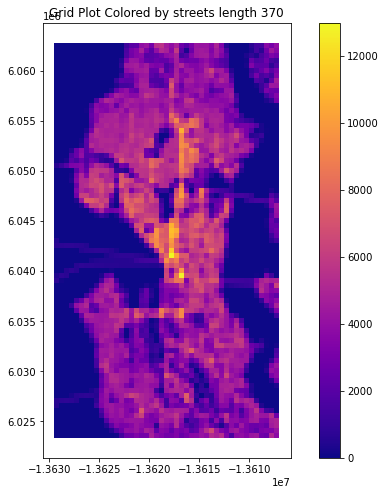

In [28]:
# Plot the GeoDataFrame and color by 'highway_length'
grid_gdf.plot(column='streets_length_370', cmap='plasma', legend=True, figsize=(10, 8))

# Add title and show plot
plt.title('Grid Plot Colored by streets length 370')
plt.show()

In [29]:
gdf.columns

Index(['WMO', 'Latitude (N+/S-)', 'Longitude (E+/W-)', 'Elevation (m)',
       'geometry', 'Total Energy [kBtu]', 'streets_length_370',
       'avg_canopy_970', 'mode_landcover_70', 'building_count_580',
       'building_area_940', 'water_area_730', 'avg_lst_520'],
      dtype='object')

In [30]:
grid_gdf.to_csv('grid_gdf_streets.csv', index=False)

# Buildings 
- 'building_count_580'
- 'building_area_940',

In [31]:
tax_fn = '/Users/amandaworthy/Big_Files/ms_buildings_kc.geojson'

tax = gpd.read_file(tax_fn, crs='EPSG:4326')

tax = tax.to_crs('EPSG:4326')

tax.crs


/Users/amandaworthy/opt/anaconda3/envs/uwgda2022/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

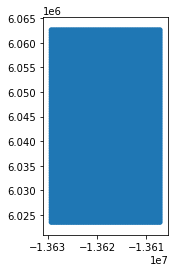

In [32]:
grid_gdf_580= buffers_dict[580]

grid_gdf_580 = grid_gdf_580.to_crs(epsg=3857)
grid_gdf = grid_gdf.to_crs(epsg=3857)
tax = tax.to_crs(epsg=3857)

grid_gdf_580.plot()

In [33]:
# Start timing
start_time = time.time()

# Ensure tax and gdflc have the same CRS
tax = tax.to_crs(grid_gdf_580.crs)

# Initialize a list to store the count of buildings within each buffer
building_counts = []
total_rows = len(grid_gdf_580)  # Total number of rows in the gdflc2 GeoDataFrame
interval = max(total_rows // 20, 1)  # Interval for 5% progress or at least 1

# Iterate over each row in the `gdflc2` GeoDataFrame
for idx, row in grid_gdf_580.iterrows():
    # Count the number of buildings within the current buffer geometry
    count = tax[tax.geometry.within(row['geometry'])].shape[0]
    building_counts.append(count)
    
    # Print percentage completion every 5%
    if (idx + 1) % interval == 0 or (idx + 1) == total_rows:
        percent_complete = (idx + 1) / total_rows * 100
        elapsed_time = time.time() - start_time
        print(f"Progress: {percent_complete:.2f}% complete. Elapsed time: {elapsed_time:.2f} seconds.")

# Add the building counts to the original `gdflc2` GeoDataFrame
grid_gdf['building_count_580'] = building_counts

# Print the total time taken
total_time = time.time() - start_time
print(f"Total time taken: {total_time:.2f} seconds.")


Progress: 4.98% complete. Elapsed time: 15.20 seconds.
Progress: 9.96% complete. Elapsed time: 30.03 seconds.
Progress: 14.94% complete. Elapsed time: 45.15 seconds.
Progress: 19.92% complete. Elapsed time: 60.62 seconds.
Progress: 24.89% complete. Elapsed time: 76.50 seconds.
Progress: 29.87% complete. Elapsed time: 92.41 seconds.
Progress: 34.85% complete. Elapsed time: 108.15 seconds.
Progress: 39.83% complete. Elapsed time: 124.23 seconds.
Progress: 44.81% complete. Elapsed time: 140.09 seconds.
Progress: 49.79% complete. Elapsed time: 155.49 seconds.
Progress: 54.77% complete. Elapsed time: 171.06 seconds.
Progress: 59.75% complete. Elapsed time: 186.86 seconds.
Progress: 64.73% complete. Elapsed time: 202.64 seconds.
Progress: 69.70% complete. Elapsed time: 218.40 seconds.
Progress: 74.68% complete. Elapsed time: 234.17 seconds.
Progress: 79.66% complete. Elapsed time: 249.84 seconds.
Progress: 84.64% complete. Elapsed time: 265.07 seconds.
Progress: 89.62% complete. Elapsed time

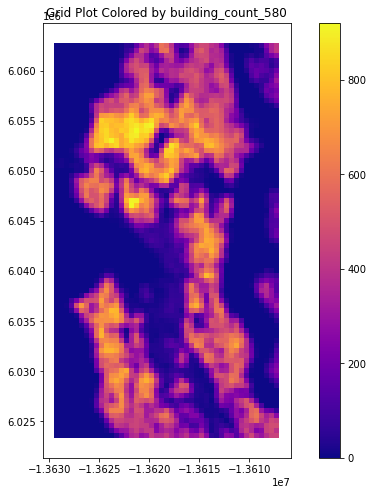

In [46]:
# Plot the GeoDataFrame and color by 'highway_length'
grid_gdf.plot(column='building_count_580', cmap='plasma', legend=True, figsize=(10, 8))

# Add title and show plot
plt.title('Grid Plot Colored by building_count_580')
plt.show()

In [36]:
grid_gdf

,geometry,min_lon,min_lat,max_lon,max_lat,streets_length_370,building_count_580
0,"POLYGON ((-13629508 6023332, -13629008 6023332...",-122.435954,47.495508,-122.431462,47.498543,0.000000,0
1,"POLYGON ((-13629508 6023832, -13629008 6023832...",-122.435954,47.498543,-122.431462,47.501577,0.000000,0
2,"POLYGON ((-13629508 6024332, -13629008 6024332...",-122.435954,47.501577,-122.431462,47.504611,0.000000,0
3,"POLYGON ((-13629508 6024832, -13629008 6024832...",-122.435954,47.504611,-122.431462,47.507646,0.000000,0
4,"POLYGON ((-13629508 6025332, -13629008 6025332...",-122.435954,47.507646,-122.431462,47.510680,0.000000,0
...,...,...,...,...,...,...,...
3550,"POLYGON ((-13607508 6060332, -13607008 6060332...",-122.238324,47.719598,-122.233833,47.722619,1676.489301,92
3551,"POLYGON ((-13607508 6060832, -13607008 6060832...",-122.238324,47.722619,-122.233833,47.725641,1265.465713,103
3552,"POLYGON ((-13607508 6061332, -13607008 6061332...",-122.238324,47.725641,-122.233833,47.728662,2818.717131,276
3553,"POLYGON ((-13607508 6061832, -13607008 6061832...",-122.238324,47.728662,-122.233833,47.731683,3646.779820,417


In [35]:
#grid_gdf.to_csv('grid_gdf_streets_buildings.csv', index=False)

<AxesSubplot:>

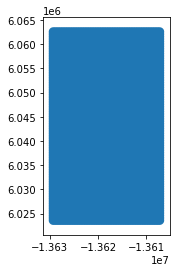

In [37]:
grid_gdf_940= buffers_dict[940]

grid_gdf_940 = grid_gdf_940.to_crs(epsg=3857)
grid_gdf = grid_gdf.to_crs(epsg=3857)
tax = tax.to_crs(epsg=3857)

grid_gdf_940.plot()

In [40]:
import geopandas as gpd
from shapely.ops import unary_union
import time

# Start timing
start_time = time.time()

# Combine the streets into a union
combined_buildings = tax.geometry.unary_union
buildings_combined = gpd.GeoDataFrame(geometry=[combined_buildings], crs=streets.crs)

# Calculate intersections in all rows
intersectionb = []
total_rows = len(grid_gdf_940)  # Total number of rows in the test GeoDataFrame

# Iterate over each row in the `test` GeoDataFrame
for idx, row in grid_gdf_940.iterrows():
    # Calculate the intersection of the buffer with the streets_combined
    intersectionbuild = buildings_combined.intersection(row['geometry'])
    intersectionbuild = unary_union(intersectionbuild)
    intersectionb.append(intersectionbuild)
    
    # Calculate and print percentage completion
    percent_complete = (idx + 1) / total_rows * 100
    elapsed_time = time.time() - start_time
    print(f"Progress: {percent_complete:.2f}% complete. Elapsed time: {elapsed_time:.2f} seconds.")

# Create a GeoDataFrame with the results
result = gpd.GeoDataFrame({'geometry': intersectionb}, crs=grid_gdf_940.crs)


grid_gdf['building_area_940'] = result['geometry'].apply(lambda geom: geom.area if geom is not None else 0)


# Print the total time taken
total_time = time.time() - start_time
print(f"Total time taken: {total_time:.2f} seconds.")


/var/folders/_0/wy7tb6qj0kn08q2vk43vjwb40000gn/T/ipykernel_2036/2496782893.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_buildings = tax.geometry.unary_union


Progress: 0.03% complete. Elapsed time: 109.06 seconds.
Progress: 0.06% complete. Elapsed time: 109.13 seconds.
Progress: 0.08% complete. Elapsed time: 109.20 seconds.
Progress: 0.11% complete. Elapsed time: 109.27 seconds.
Progress: 0.14% complete. Elapsed time: 109.35 seconds.
Progress: 0.17% complete. Elapsed time: 109.42 seconds.
Progress: 0.20% complete. Elapsed time: 109.49 seconds.
Progress: 0.23% complete. Elapsed time: 109.57 seconds.
Progress: 0.25% complete. Elapsed time: 109.66 seconds.
Progress: 0.28% complete. Elapsed time: 109.73 seconds.
Progress: 0.31% complete. Elapsed time: 109.80 seconds.
Progress: 0.34% complete. Elapsed time: 109.88 seconds.
Progress: 0.37% complete. Elapsed time: 109.95 seconds.
Progress: 0.39% complete. Elapsed time: 110.02 seconds.
Progress: 0.42% complete. Elapsed time: 110.09 seconds.
Progress: 0.45% complete. Elapsed time: 110.16 seconds.
Progress: 0.48% complete. Elapsed time: 110.24 seconds.
Progress: 0.51% complete. Elapsed time: 110.31 s

Progress: 4.16% complete. Elapsed time: 126.10 seconds.
Progress: 4.19% complete. Elapsed time: 126.17 seconds.
Progress: 4.22% complete. Elapsed time: 126.24 seconds.
Progress: 4.25% complete. Elapsed time: 126.31 seconds.
Progress: 4.28% complete. Elapsed time: 126.38 seconds.
Progress: 4.30% complete. Elapsed time: 126.45 seconds.
Progress: 4.33% complete. Elapsed time: 126.52 seconds.
Progress: 4.36% complete. Elapsed time: 126.59 seconds.
Progress: 4.39% complete. Elapsed time: 126.67 seconds.
Progress: 4.42% complete. Elapsed time: 126.75 seconds.
Progress: 4.44% complete. Elapsed time: 126.82 seconds.
Progress: 4.47% complete. Elapsed time: 126.89 seconds.
Progress: 4.50% complete. Elapsed time: 126.96 seconds.
Progress: 4.53% complete. Elapsed time: 127.03 seconds.
Progress: 4.56% complete. Elapsed time: 127.10 seconds.
Progress: 4.59% complete. Elapsed time: 127.17 seconds.
Progress: 4.61% complete. Elapsed time: 127.24 seconds.
Progress: 4.64% complete. Elapsed time: 127.32 s

Progress: 8.35% complete. Elapsed time: 143.17 seconds.
Progress: 8.38% complete. Elapsed time: 143.52 seconds.
Progress: 8.41% complete. Elapsed time: 143.88 seconds.
Progress: 8.44% complete. Elapsed time: 143.95 seconds.
Progress: 8.47% complete. Elapsed time: 144.02 seconds.
Progress: 8.50% complete. Elapsed time: 144.09 seconds.
Progress: 8.52% complete. Elapsed time: 144.16 seconds.
Progress: 8.55% complete. Elapsed time: 144.23 seconds.
Progress: 8.58% complete. Elapsed time: 144.30 seconds.
Progress: 8.61% complete. Elapsed time: 144.37 seconds.
Progress: 8.64% complete. Elapsed time: 144.44 seconds.
Progress: 8.66% complete. Elapsed time: 144.51 seconds.
Progress: 8.69% complete. Elapsed time: 144.59 seconds.
Progress: 8.72% complete. Elapsed time: 144.66 seconds.
Progress: 8.75% complete. Elapsed time: 144.73 seconds.
Progress: 8.78% complete. Elapsed time: 144.80 seconds.
Progress: 8.80% complete. Elapsed time: 144.87 seconds.
Progress: 8.83% complete. Elapsed time: 144.94 s

Progress: 12.46% complete. Elapsed time: 165.03 seconds.
Progress: 12.49% complete. Elapsed time: 165.22 seconds.
Progress: 12.52% complete. Elapsed time: 165.43 seconds.
Progress: 12.55% complete. Elapsed time: 165.65 seconds.
Progress: 12.57% complete. Elapsed time: 165.84 seconds.
Progress: 12.60% complete. Elapsed time: 165.98 seconds.
Progress: 12.63% complete. Elapsed time: 166.09 seconds.
Progress: 12.66% complete. Elapsed time: 166.17 seconds.
Progress: 12.69% complete. Elapsed time: 166.26 seconds.
Progress: 12.71% complete. Elapsed time: 166.36 seconds.
Progress: 12.74% complete. Elapsed time: 166.47 seconds.
Progress: 12.77% complete. Elapsed time: 166.58 seconds.
Progress: 12.80% complete. Elapsed time: 166.67 seconds.
Progress: 12.83% complete. Elapsed time: 166.76 seconds.
Progress: 12.86% complete. Elapsed time: 166.84 seconds.
Progress: 12.88% complete. Elapsed time: 166.91 seconds.
Progress: 12.91% complete. Elapsed time: 166.98 seconds.
Progress: 12.94% complete. Elap

Progress: 16.51% complete. Elapsed time: 189.29 seconds.
Progress: 16.54% complete. Elapsed time: 189.66 seconds.
Progress: 16.57% complete. Elapsed time: 189.73 seconds.
Progress: 16.60% complete. Elapsed time: 189.80 seconds.
Progress: 16.62% complete. Elapsed time: 189.87 seconds.
Progress: 16.65% complete. Elapsed time: 189.94 seconds.
Progress: 16.68% complete. Elapsed time: 190.01 seconds.
Progress: 16.71% complete. Elapsed time: 190.09 seconds.
Progress: 16.74% complete. Elapsed time: 190.16 seconds.
Progress: 16.77% complete. Elapsed time: 190.51 seconds.
Progress: 16.79% complete. Elapsed time: 190.59 seconds.
Progress: 16.82% complete. Elapsed time: 190.68 seconds.
Progress: 16.85% complete. Elapsed time: 190.82 seconds.
Progress: 16.88% complete. Elapsed time: 191.00 seconds.
Progress: 16.91% complete. Elapsed time: 191.22 seconds.
Progress: 16.93% complete. Elapsed time: 191.47 seconds.
Progress: 16.96% complete. Elapsed time: 191.72 seconds.
Progress: 16.99% complete. Elap

Progress: 20.56% complete. Elapsed time: 213.64 seconds.
Progress: 20.59% complete. Elapsed time: 213.89 seconds.
Progress: 20.62% complete. Elapsed time: 214.13 seconds.
Progress: 20.65% complete. Elapsed time: 214.39 seconds.
Progress: 20.68% complete. Elapsed time: 214.65 seconds.
Progress: 20.70% complete. Elapsed time: 214.90 seconds.
Progress: 20.73% complete. Elapsed time: 215.15 seconds.
Progress: 20.76% complete. Elapsed time: 215.38 seconds.
Progress: 20.79% complete. Elapsed time: 215.62 seconds.
Progress: 20.82% complete. Elapsed time: 215.85 seconds.
Progress: 20.84% complete. Elapsed time: 216.06 seconds.
Progress: 20.87% complete. Elapsed time: 216.23 seconds.
Progress: 20.90% complete. Elapsed time: 216.36 seconds.
Progress: 20.93% complete. Elapsed time: 216.45 seconds.
Progress: 20.96% complete. Elapsed time: 216.53 seconds.
Progress: 20.98% complete. Elapsed time: 216.89 seconds.
Progress: 21.01% complete. Elapsed time: 217.25 seconds.
Progress: 21.04% complete. Elap

Progress: 24.61% complete. Elapsed time: 241.71 seconds.
Progress: 24.64% complete. Elapsed time: 241.96 seconds.
Progress: 24.67% complete. Elapsed time: 242.17 seconds.
Progress: 24.70% complete. Elapsed time: 242.39 seconds.
Progress: 24.73% complete. Elapsed time: 242.64 seconds.
Progress: 24.75% complete. Elapsed time: 242.89 seconds.
Progress: 24.78% complete. Elapsed time: 243.16 seconds.
Progress: 24.81% complete. Elapsed time: 243.42 seconds.
Progress: 24.84% complete. Elapsed time: 243.67 seconds.
Progress: 24.87% complete. Elapsed time: 243.92 seconds.
Progress: 24.89% complete. Elapsed time: 244.17 seconds.
Progress: 24.92% complete. Elapsed time: 244.45 seconds.
Progress: 24.95% complete. Elapsed time: 244.72 seconds.
Progress: 24.98% complete. Elapsed time: 245.00 seconds.
Progress: 25.01% complete. Elapsed time: 245.26 seconds.
Progress: 25.04% complete. Elapsed time: 245.49 seconds.
Progress: 25.06% complete. Elapsed time: 245.72 seconds.
Progress: 25.09% complete. Elap

Progress: 28.72% complete. Elapsed time: 271.54 seconds.
Progress: 28.75% complete. Elapsed time: 271.63 seconds.
Progress: 28.78% complete. Elapsed time: 271.71 seconds.
Progress: 28.80% complete. Elapsed time: 271.79 seconds.
Progress: 28.83% complete. Elapsed time: 271.87 seconds.
Progress: 28.86% complete. Elapsed time: 271.94 seconds.
Progress: 28.89% complete. Elapsed time: 272.01 seconds.
Progress: 28.92% complete. Elapsed time: 272.13 seconds.
Progress: 28.95% complete. Elapsed time: 272.29 seconds.
Progress: 28.97% complete. Elapsed time: 272.47 seconds.
Progress: 29.00% complete. Elapsed time: 272.67 seconds.
Progress: 29.03% complete. Elapsed time: 272.89 seconds.
Progress: 29.06% complete. Elapsed time: 273.12 seconds.
Progress: 29.09% complete. Elapsed time: 273.35 seconds.
Progress: 29.11% complete. Elapsed time: 273.57 seconds.
Progress: 29.14% complete. Elapsed time: 273.80 seconds.
Progress: 29.17% complete. Elapsed time: 274.04 seconds.
Progress: 29.20% complete. Elap

Progress: 32.77% complete. Elapsed time: 298.03 seconds.
Progress: 32.80% complete. Elapsed time: 298.33 seconds.
Progress: 32.83% complete. Elapsed time: 298.64 seconds.
Progress: 32.86% complete. Elapsed time: 298.95 seconds.
Progress: 32.88% complete. Elapsed time: 299.26 seconds.
Progress: 32.91% complete. Elapsed time: 299.56 seconds.
Progress: 32.94% complete. Elapsed time: 299.83 seconds.
Progress: 32.97% complete. Elapsed time: 300.09 seconds.
Progress: 33.00% complete. Elapsed time: 300.33 seconds.
Progress: 33.02% complete. Elapsed time: 300.56 seconds.
Progress: 33.05% complete. Elapsed time: 300.77 seconds.
Progress: 33.08% complete. Elapsed time: 300.95 seconds.
Progress: 33.11% complete. Elapsed time: 301.09 seconds.
Progress: 33.14% complete. Elapsed time: 301.22 seconds.
Progress: 33.16% complete. Elapsed time: 301.35 seconds.
Progress: 33.19% complete. Elapsed time: 301.51 seconds.
Progress: 33.22% complete. Elapsed time: 301.67 seconds.
Progress: 33.25% complete. Elap

Progress: 36.82% complete. Elapsed time: 326.12 seconds.
Progress: 36.85% complete. Elapsed time: 326.38 seconds.
Progress: 36.88% complete. Elapsed time: 326.66 seconds.
Progress: 36.91% complete. Elapsed time: 326.95 seconds.
Progress: 36.93% complete. Elapsed time: 327.21 seconds.
Progress: 36.96% complete. Elapsed time: 327.44 seconds.
Progress: 36.99% complete. Elapsed time: 327.62 seconds.
Progress: 37.02% complete. Elapsed time: 327.81 seconds.
Progress: 37.05% complete. Elapsed time: 327.99 seconds.
Progress: 37.07% complete. Elapsed time: 328.19 seconds.
Progress: 37.10% complete. Elapsed time: 328.42 seconds.
Progress: 37.13% complete. Elapsed time: 328.68 seconds.
Progress: 37.16% complete. Elapsed time: 328.94 seconds.
Progress: 37.19% complete. Elapsed time: 329.22 seconds.
Progress: 37.22% complete. Elapsed time: 329.50 seconds.
Progress: 37.24% complete. Elapsed time: 329.81 seconds.
Progress: 37.27% complete. Elapsed time: 330.15 seconds.
Progress: 37.30% complete. Elap

Progress: 40.93% complete. Elapsed time: 355.41 seconds.
Progress: 40.96% complete. Elapsed time: 355.79 seconds.
Progress: 40.98% complete. Elapsed time: 356.16 seconds.
Progress: 41.01% complete. Elapsed time: 356.53 seconds.
Progress: 41.04% complete. Elapsed time: 356.60 seconds.
Progress: 41.07% complete. Elapsed time: 356.68 seconds.
Progress: 41.10% complete. Elapsed time: 356.77 seconds.
Progress: 41.13% complete. Elapsed time: 356.86 seconds.
Progress: 41.15% complete. Elapsed time: 356.97 seconds.
Progress: 41.18% complete. Elapsed time: 357.10 seconds.
Progress: 41.21% complete. Elapsed time: 357.24 seconds.
Progress: 41.24% complete. Elapsed time: 357.44 seconds.
Progress: 41.27% complete. Elapsed time: 357.66 seconds.
Progress: 41.29% complete. Elapsed time: 357.90 seconds.
Progress: 41.32% complete. Elapsed time: 358.15 seconds.
Progress: 41.35% complete. Elapsed time: 358.42 seconds.
Progress: 41.38% complete. Elapsed time: 358.66 seconds.
Progress: 41.41% complete. Elap

Progress: 45.01% complete. Elapsed time: 382.10 seconds.
Progress: 45.04% complete. Elapsed time: 382.18 seconds.
Progress: 45.06% complete. Elapsed time: 382.26 seconds.
Progress: 45.09% complete. Elapsed time: 382.34 seconds.
Progress: 45.12% complete. Elapsed time: 382.42 seconds.
Progress: 45.15% complete. Elapsed time: 382.50 seconds.
Progress: 45.18% complete. Elapsed time: 382.58 seconds.
Progress: 45.20% complete. Elapsed time: 382.66 seconds.
Progress: 45.23% complete. Elapsed time: 382.74 seconds.
Progress: 45.26% complete. Elapsed time: 382.82 seconds.
Progress: 45.29% complete. Elapsed time: 382.90 seconds.
Progress: 45.32% complete. Elapsed time: 382.97 seconds.
Progress: 45.34% complete. Elapsed time: 383.05 seconds.
Progress: 45.37% complete. Elapsed time: 383.12 seconds.
Progress: 45.40% complete. Elapsed time: 383.49 seconds.
Progress: 45.43% complete. Elapsed time: 383.56 seconds.
Progress: 45.46% complete. Elapsed time: 383.64 seconds.
Progress: 45.49% complete. Elap

Progress: 49.09% complete. Elapsed time: 403.59 seconds.
Progress: 49.11% complete. Elapsed time: 403.71 seconds.
Progress: 49.14% complete. Elapsed time: 403.82 seconds.
Progress: 49.17% complete. Elapsed time: 403.93 seconds.
Progress: 49.20% complete. Elapsed time: 404.04 seconds.
Progress: 49.23% complete. Elapsed time: 404.14 seconds.
Progress: 49.25% complete. Elapsed time: 404.23 seconds.
Progress: 49.28% complete. Elapsed time: 404.32 seconds.
Progress: 49.31% complete. Elapsed time: 404.41 seconds.
Progress: 49.34% complete. Elapsed time: 404.49 seconds.
Progress: 49.37% complete. Elapsed time: 404.58 seconds.
Progress: 49.40% complete. Elapsed time: 404.67 seconds.
Progress: 49.42% complete. Elapsed time: 404.77 seconds.
Progress: 49.45% complete. Elapsed time: 404.86 seconds.
Progress: 49.48% complete. Elapsed time: 404.95 seconds.
Progress: 49.51% complete. Elapsed time: 405.03 seconds.
Progress: 49.54% complete. Elapsed time: 405.11 seconds.
Progress: 49.56% complete. Elap

Progress: 53.14% complete. Elapsed time: 423.85 seconds.
Progress: 53.16% complete. Elapsed time: 424.02 seconds.
Progress: 53.19% complete. Elapsed time: 424.20 seconds.
Progress: 53.22% complete. Elapsed time: 424.37 seconds.
Progress: 53.25% complete. Elapsed time: 424.54 seconds.
Progress: 53.28% complete. Elapsed time: 424.73 seconds.
Progress: 53.31% complete. Elapsed time: 424.92 seconds.
Progress: 53.33% complete. Elapsed time: 425.10 seconds.
Progress: 53.36% complete. Elapsed time: 425.26 seconds.
Progress: 53.39% complete. Elapsed time: 425.42 seconds.
Progress: 53.42% complete. Elapsed time: 425.59 seconds.
Progress: 53.45% complete. Elapsed time: 425.74 seconds.
Progress: 53.47% complete. Elapsed time: 425.91 seconds.
Progress: 53.50% complete. Elapsed time: 426.05 seconds.
Progress: 53.53% complete. Elapsed time: 426.17 seconds.
Progress: 53.56% complete. Elapsed time: 426.28 seconds.
Progress: 53.59% complete. Elapsed time: 426.42 seconds.
Progress: 53.61% complete. Elap

Progress: 57.19% complete. Elapsed time: 445.94 seconds.
Progress: 57.22% complete. Elapsed time: 446.20 seconds.
Progress: 57.24% complete. Elapsed time: 446.43 seconds.
Progress: 57.27% complete. Elapsed time: 446.63 seconds.
Progress: 57.30% complete. Elapsed time: 446.84 seconds.
Progress: 57.33% complete. Elapsed time: 447.08 seconds.
Progress: 57.36% complete. Elapsed time: 447.32 seconds.
Progress: 57.38% complete. Elapsed time: 447.57 seconds.
Progress: 57.41% complete. Elapsed time: 447.82 seconds.
Progress: 57.44% complete. Elapsed time: 448.06 seconds.
Progress: 57.47% complete. Elapsed time: 448.27 seconds.
Progress: 57.50% complete. Elapsed time: 448.44 seconds.
Progress: 57.52% complete. Elapsed time: 448.59 seconds.
Progress: 57.55% complete. Elapsed time: 448.75 seconds.
Progress: 57.58% complete. Elapsed time: 448.93 seconds.
Progress: 57.61% complete. Elapsed time: 449.12 seconds.
Progress: 57.64% complete. Elapsed time: 449.32 seconds.
Progress: 57.67% complete. Elap

Progress: 61.24% complete. Elapsed time: 470.70 seconds.
Progress: 61.27% complete. Elapsed time: 470.91 seconds.
Progress: 61.29% complete. Elapsed time: 471.09 seconds.
Progress: 61.32% complete. Elapsed time: 471.27 seconds.
Progress: 61.35% complete. Elapsed time: 471.46 seconds.
Progress: 61.38% complete. Elapsed time: 471.63 seconds.
Progress: 61.41% complete. Elapsed time: 471.77 seconds.
Progress: 61.43% complete. Elapsed time: 471.90 seconds.
Progress: 61.46% complete. Elapsed time: 472.01 seconds.
Progress: 61.49% complete. Elapsed time: 472.12 seconds.
Progress: 61.52% complete. Elapsed time: 472.25 seconds.
Progress: 61.55% complete. Elapsed time: 472.41 seconds.
Progress: 61.58% complete. Elapsed time: 472.61 seconds.
Progress: 61.60% complete. Elapsed time: 472.86 seconds.
Progress: 61.63% complete. Elapsed time: 473.11 seconds.
Progress: 61.66% complete. Elapsed time: 473.36 seconds.
Progress: 61.69% complete. Elapsed time: 473.59 seconds.
Progress: 61.72% complete. Elap

Progress: 65.29% complete. Elapsed time: 496.83 seconds.
Progress: 65.32% complete. Elapsed time: 497.00 seconds.
Progress: 65.34% complete. Elapsed time: 497.20 seconds.
Progress: 65.37% complete. Elapsed time: 497.41 seconds.
Progress: 65.40% complete. Elapsed time: 497.63 seconds.
Progress: 65.43% complete. Elapsed time: 497.86 seconds.
Progress: 65.46% complete. Elapsed time: 498.08 seconds.
Progress: 65.49% complete. Elapsed time: 498.32 seconds.
Progress: 65.51% complete. Elapsed time: 498.58 seconds.
Progress: 65.54% complete. Elapsed time: 498.83 seconds.
Progress: 65.57% complete. Elapsed time: 499.11 seconds.
Progress: 65.60% complete. Elapsed time: 499.38 seconds.
Progress: 65.63% complete. Elapsed time: 499.65 seconds.
Progress: 65.65% complete. Elapsed time: 499.93 seconds.
Progress: 65.68% complete. Elapsed time: 500.18 seconds.
Progress: 65.71% complete. Elapsed time: 500.41 seconds.
Progress: 65.74% complete. Elapsed time: 500.61 seconds.
Progress: 65.77% complete. Elap

Progress: 69.34% complete. Elapsed time: 523.21 seconds.
Progress: 69.37% complete. Elapsed time: 523.42 seconds.
Progress: 69.40% complete. Elapsed time: 523.63 seconds.
Progress: 69.42% complete. Elapsed time: 523.84 seconds.
Progress: 69.45% complete. Elapsed time: 524.05 seconds.
Progress: 69.48% complete. Elapsed time: 524.26 seconds.
Progress: 69.51% complete. Elapsed time: 524.46 seconds.
Progress: 69.54% complete. Elapsed time: 524.66 seconds.
Progress: 69.56% complete. Elapsed time: 524.84 seconds.
Progress: 69.59% complete. Elapsed time: 525.03 seconds.
Progress: 69.62% complete. Elapsed time: 525.22 seconds.
Progress: 69.65% complete. Elapsed time: 525.41 seconds.
Progress: 69.68% complete. Elapsed time: 525.60 seconds.
Progress: 69.70% complete. Elapsed time: 525.78 seconds.
Progress: 69.73% complete. Elapsed time: 525.97 seconds.
Progress: 69.76% complete. Elapsed time: 526.16 seconds.
Progress: 69.79% complete. Elapsed time: 526.38 seconds.
Progress: 69.82% complete. Elap

Progress: 73.39% complete. Elapsed time: 550.43 seconds.
Progress: 73.42% complete. Elapsed time: 550.52 seconds.
Progress: 73.45% complete. Elapsed time: 550.60 seconds.
Progress: 73.47% complete. Elapsed time: 550.69 seconds.
Progress: 73.50% complete. Elapsed time: 550.78 seconds.
Progress: 73.53% complete. Elapsed time: 550.88 seconds.
Progress: 73.56% complete. Elapsed time: 551.00 seconds.
Progress: 73.59% complete. Elapsed time: 551.14 seconds.
Progress: 73.61% complete. Elapsed time: 551.30 seconds.
Progress: 73.64% complete. Elapsed time: 551.47 seconds.
Progress: 73.67% complete. Elapsed time: 551.66 seconds.
Progress: 73.70% complete. Elapsed time: 551.85 seconds.
Progress: 73.73% complete. Elapsed time: 552.04 seconds.
Progress: 73.76% complete. Elapsed time: 552.23 seconds.
Progress: 73.78% complete. Elapsed time: 552.42 seconds.
Progress: 73.81% complete. Elapsed time: 552.63 seconds.
Progress: 73.84% complete. Elapsed time: 552.85 seconds.
Progress: 73.87% complete. Elap

Progress: 77.44% complete. Elapsed time: 574.78 seconds.
Progress: 77.47% complete. Elapsed time: 574.98 seconds.
Progress: 77.50% complete. Elapsed time: 575.19 seconds.
Progress: 77.52% complete. Elapsed time: 575.39 seconds.
Progress: 77.55% complete. Elapsed time: 575.58 seconds.
Progress: 77.58% complete. Elapsed time: 575.77 seconds.
Progress: 77.61% complete. Elapsed time: 575.94 seconds.
Progress: 77.64% complete. Elapsed time: 576.10 seconds.
Progress: 77.67% complete. Elapsed time: 576.25 seconds.
Progress: 77.69% complete. Elapsed time: 576.37 seconds.
Progress: 77.72% complete. Elapsed time: 576.49 seconds.
Progress: 77.75% complete. Elapsed time: 576.61 seconds.
Progress: 77.78% complete. Elapsed time: 576.71 seconds.
Progress: 77.81% complete. Elapsed time: 576.84 seconds.
Progress: 77.83% complete. Elapsed time: 576.95 seconds.
Progress: 77.86% complete. Elapsed time: 577.06 seconds.
Progress: 77.89% complete. Elapsed time: 577.16 seconds.
Progress: 77.92% complete. Elap

Progress: 81.49% complete. Elapsed time: 600.92 seconds.
Progress: 81.52% complete. Elapsed time: 601.08 seconds.
Progress: 81.55% complete. Elapsed time: 601.25 seconds.
Progress: 81.58% complete. Elapsed time: 601.43 seconds.
Progress: 81.60% complete. Elapsed time: 601.62 seconds.
Progress: 81.63% complete. Elapsed time: 601.84 seconds.
Progress: 81.66% complete. Elapsed time: 602.10 seconds.
Progress: 81.69% complete. Elapsed time: 602.33 seconds.
Progress: 81.72% complete. Elapsed time: 602.58 seconds.
Progress: 81.74% complete. Elapsed time: 602.79 seconds.
Progress: 81.77% complete. Elapsed time: 602.97 seconds.
Progress: 81.80% complete. Elapsed time: 603.12 seconds.
Progress: 81.83% complete. Elapsed time: 603.26 seconds.
Progress: 81.86% complete. Elapsed time: 603.39 seconds.
Progress: 81.88% complete. Elapsed time: 603.52 seconds.
Progress: 81.91% complete. Elapsed time: 603.64 seconds.
Progress: 81.94% complete. Elapsed time: 603.77 seconds.
Progress: 81.97% complete. Elap

Progress: 85.60% complete. Elapsed time: 625.72 seconds.
Progress: 85.63% complete. Elapsed time: 625.79 seconds.
Progress: 85.65% complete. Elapsed time: 625.86 seconds.
Progress: 85.68% complete. Elapsed time: 625.94 seconds.
Progress: 85.71% complete. Elapsed time: 626.01 seconds.
Progress: 85.74% complete. Elapsed time: 626.08 seconds.
Progress: 85.77% complete. Elapsed time: 626.15 seconds.
Progress: 85.79% complete. Elapsed time: 626.22 seconds.
Progress: 85.82% complete. Elapsed time: 626.29 seconds.
Progress: 85.85% complete. Elapsed time: 626.65 seconds.
Progress: 85.88% complete. Elapsed time: 627.01 seconds.
Progress: 85.91% complete. Elapsed time: 627.39 seconds.
Progress: 85.94% complete. Elapsed time: 627.47 seconds.
Progress: 85.96% complete. Elapsed time: 627.55 seconds.
Progress: 85.99% complete. Elapsed time: 627.65 seconds.
Progress: 86.02% complete. Elapsed time: 627.76 seconds.
Progress: 86.05% complete. Elapsed time: 627.89 seconds.
Progress: 86.08% complete. Elap

Progress: 89.70% complete. Elapsed time: 648.99 seconds.
Progress: 89.73% complete. Elapsed time: 649.11 seconds.
Progress: 89.76% complete. Elapsed time: 649.23 seconds.
Progress: 89.79% complete. Elapsed time: 649.33 seconds.
Progress: 89.82% complete. Elapsed time: 649.41 seconds.
Progress: 89.85% complete. Elapsed time: 649.49 seconds.
Progress: 89.87% complete. Elapsed time: 649.85 seconds.
Progress: 89.90% complete. Elapsed time: 650.21 seconds.
Progress: 89.93% complete. Elapsed time: 650.28 seconds.
Progress: 89.96% complete. Elapsed time: 650.36 seconds.
Progress: 89.99% complete. Elapsed time: 650.71 seconds.
Progress: 90.01% complete. Elapsed time: 651.07 seconds.
Progress: 90.04% complete. Elapsed time: 651.43 seconds.
Progress: 90.07% complete. Elapsed time: 651.79 seconds.
Progress: 90.10% complete. Elapsed time: 652.15 seconds.
Progress: 90.13% complete. Elapsed time: 652.51 seconds.
Progress: 90.15% complete. Elapsed time: 652.86 seconds.
Progress: 90.18% complete. Elap

Progress: 93.78% complete. Elapsed time: 674.38 seconds.
Progress: 93.81% complete. Elapsed time: 674.46 seconds.
Progress: 93.84% complete. Elapsed time: 674.82 seconds.
Progress: 93.87% complete. Elapsed time: 675.18 seconds.
Progress: 93.90% complete. Elapsed time: 675.55 seconds.
Progress: 93.92% complete. Elapsed time: 675.91 seconds.
Progress: 93.95% complete. Elapsed time: 676.28 seconds.
Progress: 93.98% complete. Elapsed time: 676.63 seconds.
Progress: 94.01% complete. Elapsed time: 676.99 seconds.
Progress: 94.04% complete. Elapsed time: 677.07 seconds.
Progress: 94.06% complete. Elapsed time: 677.16 seconds.
Progress: 94.09% complete. Elapsed time: 677.27 seconds.
Progress: 94.12% complete. Elapsed time: 677.40 seconds.
Progress: 94.15% complete. Elapsed time: 677.56 seconds.
Progress: 94.18% complete. Elapsed time: 677.74 seconds.
Progress: 94.21% complete. Elapsed time: 677.90 seconds.
Progress: 94.23% complete. Elapsed time: 678.04 seconds.
Progress: 94.26% complete. Elap

Progress: 97.83% complete. Elapsed time: 699.74 seconds.
Progress: 97.86% complete. Elapsed time: 699.95 seconds.
Progress: 97.89% complete. Elapsed time: 700.13 seconds.
Progress: 97.92% complete. Elapsed time: 700.28 seconds.
Progress: 97.95% complete. Elapsed time: 700.38 seconds.
Progress: 97.97% complete. Elapsed time: 700.46 seconds.
Progress: 98.00% complete. Elapsed time: 700.81 seconds.
Progress: 98.03% complete. Elapsed time: 701.17 seconds.
Progress: 98.06% complete. Elapsed time: 701.25 seconds.
Progress: 98.09% complete. Elapsed time: 701.34 seconds.
Progress: 98.12% complete. Elapsed time: 701.46 seconds.
Progress: 98.14% complete. Elapsed time: 701.59 seconds.
Progress: 98.17% complete. Elapsed time: 701.74 seconds.
Progress: 98.20% complete. Elapsed time: 701.88 seconds.
Progress: 98.23% complete. Elapsed time: 702.02 seconds.
Progress: 98.26% complete. Elapsed time: 702.14 seconds.
Progress: 98.28% complete. Elapsed time: 702.25 seconds.
Progress: 98.31% complete. Elap

In [41]:
grid_gdf

,geometry,min_lon,min_lat,max_lon,max_lat,streets_length_370,building_count_580,building_area_940
0,"POLYGON ((-13629508 6023332, -13629008 6023332...",-122.435954,47.495508,-122.431462,47.498543,0.000000,0,0.000000
1,"POLYGON ((-13629508 6023832, -13629008 6023832...",-122.435954,47.498543,-122.431462,47.501577,0.000000,0,0.000000
2,"POLYGON ((-13629508 6024332, -13629008 6024332...",-122.435954,47.501577,-122.431462,47.504611,0.000000,0,0.000000
3,"POLYGON ((-13629508 6024832, -13629008 6024832...",-122.435954,47.504611,-122.431462,47.507646,0.000000,0,0.000000
4,"POLYGON ((-13629508 6025332, -13629008 6025332...",-122.435954,47.507646,-122.431462,47.510680,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...
3550,"POLYGON ((-13607508 6060332, -13607008 6060332...",-122.238324,47.719598,-122.233833,47.722619,1676.489301,92,150868.048308
3551,"POLYGON ((-13607508 6060832, -13607008 6060832...",-122.238324,47.722619,-122.233833,47.725641,1265.465713,103,193692.502668
3552,"POLYGON ((-13607508 6061332, -13607008 6061332...",-122.238324,47.725641,-122.233833,47.728662,2818.717131,276,319916.899802
3553,"POLYGON ((-13607508 6061832, -13607008 6061832...",-122.238324,47.728662,-122.233833,47.731683,3646.779820,417,437109.267673


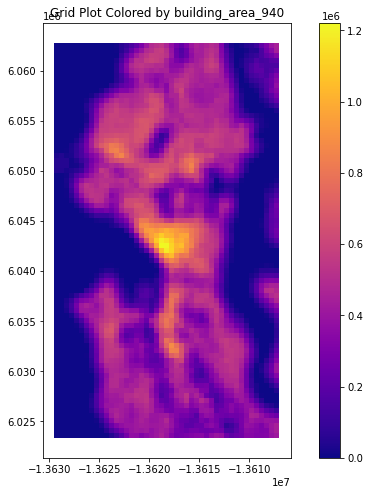

In [42]:
# Plot the GeoDataFrame and color by 'highway_length'
grid_gdf.plot(column='building_area_940', cmap='plasma', legend=True, figsize=(10, 8))

# Add title and show plot
plt.title('Grid Plot Colored by building_area_940')
plt.show()

In [47]:
grid_gdf.to_csv('grid_gdf_streets_buildingslanda.csv', index=False)

# Now we sample 'avg_canopy_970' 

In [48]:
from rasterio.crs import CRS
import rioxarray as rxr
import xarray as xr

tcc_path= '/Users/amandaworthy/Paper_3_GEE_files/tcc_bigger_seattle.tif'

dataarray_tcc= xr.open_rasterio(tcc_path)

dataarray_tcc

/var/folders/_0/wy7tb6qj0kn08q2vk43vjwb40000gn/T/ipykernel_2036/675147104.py:7: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  dataarray_tcc= xr.open_rasterio(tcc_path)


<xarray.DataArray (band: 1, y: 1475, x: 1135)>
[1674125 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 47.78 47.78 47.77 47.77 ... 47.38 47.38 47.38 47.38
  * x        (x) float64 -122.5 -122.5 -122.5 -122.5 ... -122.2 -122.2 -122.2
Attributes:
    transform:      (0.00026949458523585647, 0.0, -122.46426841204837, 0.0, -...
    crs:            +init=epsg:4326
    res:            (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('NLCD_Percent_Tree_Canopy_Cover',)
    AREA_OR_POINT:  Area

<AxesSubplot:>

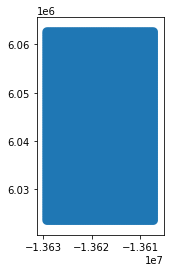

In [49]:
grid_gdf_970= buffers_dict[970]

grid_gdf_970 = grid_gdf_970.to_crs(epsg=3857)
grid_gdf = grid_gdf.to_crs(epsg=3857)

grid_gdf_970.plot()

In [50]:
# Function to calculate the average tree canopy coverage for each geometry
def calculate_average_canopy(geometry, raster):
    try:
        # Clip the raster using the geometry
        clipped_raster = raster.rio.clip([geometry], grid_gdf_970.crs, drop=True)
        
        # Calculate the mean of the non-NaN values
        mean_canopy = clipped_raster.mean().item()
        
        # Handle cases where the mean is NaN (e.g., no intersection)
        if np.isnan(mean_canopy):
            return None  # or return 0 if you prefer to use 0 as a default value
        
        return mean_canopy
    
    except Exception as e:
        # Handle any unexpected errors
        print(f"Error processing geometry: {e}")
        return None

# Start timing
start_time = time.time()

# Total number of rows
total_rows = len(grid_gdf_970)

# Create a list to store average canopy values
avg_canopy_values = []

# Iterate through each geometry and calculate the average canopy
for i, geometry in enumerate(grid_gdf_970['geometry']):
    avg_canopy = calculate_average_canopy(geometry, dataarray_tcc)
    avg_canopy_values.append(avg_canopy)
    
    # Calculate and print progress every 5%
    if (i + 1) % (total_rows // 20) == 0:  # 20 intervals (5% each)
        elapsed_time = time.time() - start_time
        progress = (i + 1) / total_rows * 100
        print(f"Progress: {progress:.2f}% - Time elapsed: {elapsed_time:.2f} seconds")

# Assign the calculated values to the GeoDataFrame
grid_gdf['avg_canopy_970'] = avg_canopy_values

# End timing
end_time = time.time()
total_elapsed_time = end_time - start_time

# Print the total elapsed time
print(f"Total elapsed time for calculating average canopy coverage: {total_elapsed_time:.2f} seconds")

# Display the first few rows of the GeoDataFrame
#grid_gdf.head()

Warning 1: +init=epsg:XXXX syntax is deprecated. It might return a CRS with a non-EPSG compliant axis order.


Error processing geometry: cannot convert float NaN to integer
Progress: 4.98% - Time elapsed: 4.95 seconds
Progress: 9.96% - Time elapsed: 10.48 seconds
Progress: 14.94% - Time elapsed: 15.35 seconds
Progress: 19.92% - Time elapsed: 20.16 seconds
Progress: 24.89% - Time elapsed: 25.00 seconds
Progress: 29.87% - Time elapsed: 29.86 seconds
Progress: 34.85% - Time elapsed: 34.67 seconds
Progress: 39.83% - Time elapsed: 39.48 seconds
Progress: 44.81% - Time elapsed: 44.40 seconds
Progress: 49.79% - Time elapsed: 49.24 seconds
Progress: 54.77% - Time elapsed: 54.06 seconds
Progress: 59.75% - Time elapsed: 58.93 seconds
Progress: 64.73% - Time elapsed: 63.75 seconds
Progress: 69.70% - Time elapsed: 68.61 seconds
Progress: 74.68% - Time elapsed: 73.50 seconds
Progress: 79.66% - Time elapsed: 78.36 seconds
Progress: 84.64% - Time elapsed: 83.17 seconds
Progress: 89.62% - Time elapsed: 87.97 seconds
Progress: 94.60% - Time elapsed: 92.89 seconds
Progress: 99.58% - Time elapsed: 97.77 seconds


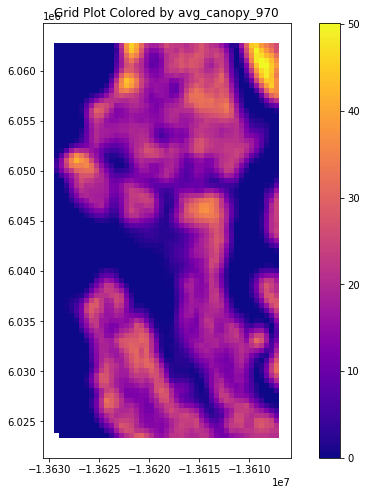

In [51]:
# Plot the GeoDataFrame and color by 'highway_length'
grid_gdf.plot(column='avg_canopy_970', cmap='plasma', legend=True, figsize=(10, 8))

# Add title and show plot
plt.title('Grid Plot Colored by avg_canopy_970')
plt.show()

In [52]:
grid_gdf.to_csv('grid_gdf_streets_buildingslanda_tc.csv', index=False)

# Landcover ('mode_landcover_70') 

In [53]:
landcover= xr.open_rasterio('/Users/amandaworthy/Paper_3_GEE_files/clipped_landuse_seattle.tif')

landcover

/var/folders/_0/wy7tb6qj0kn08q2vk43vjwb40000gn/T/ipykernel_2036/243754384.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  landcover= xr.open_rasterio('/Users/amandaworthy/Paper_3_GEE_files/clipped_landuse_seattle.tif')


<xarray.DataArray (band: 1, y: 1321, x: 1165)>
[1538965 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 47.78 47.78 47.78 47.78 ... 47.42 47.42 47.42 47.42
  * x        (x) float64 -122.5 -122.5 -122.5 -122.5 ... -122.2 -122.2 -122.2
Attributes:
    transform:      (0.00026949458523585647, 0.0, -122.47370072253162, 0.0, -...
    crs:            +init=epsg:4326
    res:            (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('landcover',)
    AREA_OR_POINT:  Area

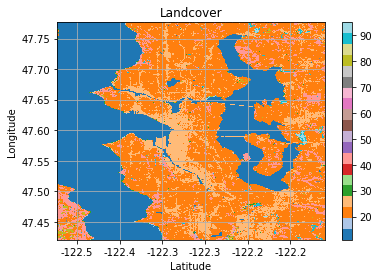

In [54]:
landcover.plot(cmap='tab20')
plt.title('Landcover')

plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# Add axis labels
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Optionally, customize other aspects of the plot
plt.grid(True)

# Show the plot
plt.show()

<AxesSubplot:>

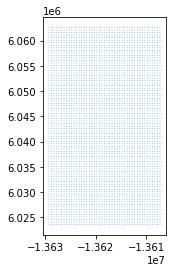

In [55]:
grid_gdf_70= buffers_dict[70]

grid_gdf_70 = grid_gdf_70.to_crs(epsg=3857)
grid_gdf = grid_gdf.to_crs(epsg=3857)

grid_gdf_70.plot()

In [56]:
import geopandas as gpd
import rioxarray
import numpy as np
import time
from scipy import stats

# Function to calculate the mode of land cover for each geometry
def calculate_mode_landcover(geometry, raster):
    try:
        # Clip the raster using the geometry
        clipped_raster = raster.rio.clip([geometry], grid_gdf_70.crs, drop=True)
        
        # Flatten the raster values to 1D array
        values = clipped_raster.values.flatten()
        
        # Remove NaNs
        values = values[~np.isnan(values)]
        
        if len(values) == 0:
            return None  # No data in the clipped raster
        
        # Calculate the mode of the values
        mode_value, count = stats.mode(values, axis=None)
        
        return mode_value[0]
    
    except Exception as e:
        # Handle any unexpected errors
        print(f"Error processing geometry: {e}")
        return None

# Start timing
start_time = time.time()

# Total number of rows
total_rows = len(grid_gdf)

# Create a list to store mode land cover values
mode_landcover_values = []

# Iterate through each geometry and calculate the mode land cover
for i, geometry in enumerate(grid_gdf_70['geometry']):
    mode_landcover = calculate_mode_landcover(geometry, landcover)
    mode_landcover_values.append(mode_landcover)
    
    # Calculate and print progress every 5%
    if (i + 1) % (total_rows // 20) == 0:  # 20 intervals (5% each)
        elapsed_time = time.time() - start_time
        progress = (i + 1) / total_rows * 100
        print(f"Progress: {progress:.2f}% - Time elapsed: {elapsed_time:.2f} seconds")

# Assign the calculated values to the GeoDataFrame
grid_gdf['mode_landcover_70'] = mode_landcover_values

# End timing
end_time = time.time()
total_elapsed_time = end_time - start_time

# Print the total elapsed time
print(f"Total elapsed time for calculating mode land cover: {total_elapsed_time:.2f} seconds")


Error processing geometry: cannot convert float NaN to integer
Progress: 4.98% - Time elapsed: 4.64 seconds
Progress: 9.96% - Time elapsed: 9.34 seconds
Progress: 14.94% - Time elapsed: 14.13 seconds
Progress: 19.92% - Time elapsed: 18.89 seconds
Progress: 24.89% - Time elapsed: 23.66 seconds
Progress: 29.87% - Time elapsed: 28.36 seconds
Progress: 34.85% - Time elapsed: 33.08 seconds
Progress: 39.83% - Time elapsed: 38.09 seconds
Progress: 44.81% - Time elapsed: 42.81 seconds
Progress: 49.79% - Time elapsed: 47.45 seconds
Progress: 54.77% - Time elapsed: 52.14 seconds
Progress: 59.75% - Time elapsed: 56.87 seconds
Progress: 64.73% - Time elapsed: 61.55 seconds
Progress: 69.70% - Time elapsed: 66.23 seconds
Progress: 74.68% - Time elapsed: 70.97 seconds
Progress: 79.66% - Time elapsed: 75.64 seconds
Progress: 84.64% - Time elapsed: 80.30 seconds
Progress: 89.62% - Time elapsed: 84.95 seconds
Progress: 94.60% - Time elapsed: 89.63 seconds
Progress: 99.58% - Time elapsed: 94.26 seconds
T

In [57]:
grid_gdf['mode_landcover_70'] = grid_gdf['mode_landcover_70'].fillna(0)

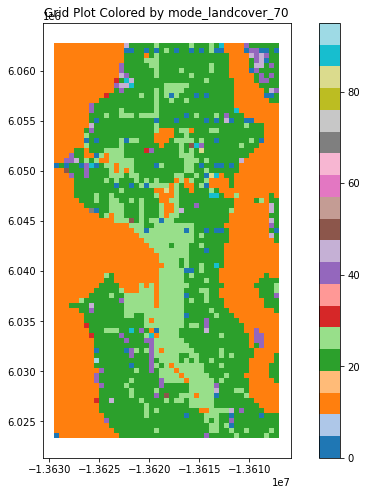

In [58]:
# Plot the GeoDataFrame and color by 'highway_length'
grid_gdf.plot(column='mode_landcover_70', cmap='tab20', legend=True, figsize=(10, 8))

# Add title and show plot
plt.title('Grid Plot Colored by mode_landcover_70')
plt.show()

In [59]:
grid_gdf.to_csv('grid_gdf_streets_buildingslanda_tc_lc.csv', index=False)

# Water Bodies ('water_area_730') 

In [60]:
water_fn = '/Users/amandaworthy/PHI_Big_Files/Visible_Surface_Water.geojson'

water = gpd.read_file(water_fn, crs='EPSG:3857')

water = water.to_crs('EPSG:3857')

water.crs

/Users/amandaworthy/opt/anaconda3/envs/uwgda2022/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(


<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [61]:
bounds = grid_gdf.total_bounds
bounds

water = water.to_crs('EPSG:3857')

gdf = gdf.to_crs('EPSG:3857')

In [62]:
from shapely.geometry import box

# Get the total bounds of gdf
minx, miny, maxx, maxy = grid_gdf.total_bounds

# Expand the bounds by 0.2 units in all directions
buffer = 0.01
expanded_minx = minx - buffer
expanded_miny = miny - buffer
expanded_maxx = maxx + buffer
expanded_maxy = maxy + buffer

# Create a bounding box polygon with the expanded bounds
expanded_bounds = box(expanded_minx, expanded_miny, expanded_maxx, expanded_maxy)

# Crop water_combined to the expanded bounds
cropped_water = water.intersection(expanded_bounds)

In [63]:
# Combine all water polygons into a single geometry using unary_union
combined_water = cropped_water.geometry.unary_union
water_combined = gpd.GeoDataFrame(geometry=[combined_water], crs=water.crs)

/var/folders/_0/wy7tb6qj0kn08q2vk43vjwb40000gn/T/ipykernel_2036/3846650959.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_water = cropped_water.geometry.unary_union


<AxesSubplot:>

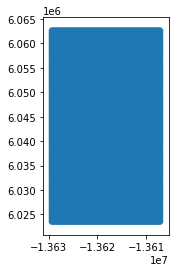

In [64]:
grid_gdf_730= buffers_dict[730]

grid_gdf_730 = grid_gdf_730.to_crs(epsg=3857)
grid_gdf = grid_gdf.to_crs(epsg=3857)

grid_gdf_730.plot()

In [65]:
start_time = time.time()

# Combine all water polygons into a single geometry using unary_union
combined_water = cropped_water.geometry.unary_union
water_combined = gpd.GeoDataFrame(geometry=[combined_water], crs=water.crs)

# Initialize a list to store the intersection areas
water_intersections = []
total_rows = len(grid_gdf_730)  # Total number of rows in the gdf GeoDataFrame
interval = total_rows // 20  # Interval for 5% progress

# Iterate over each row in the `gdf` GeoDataFrame
for idx, row in grid_gdf_730.iterrows():
    # Calculate the intersection of each gdf geometry with the combined water geometry
    intersectionwa = combined_water.intersection(row['geometry'])
    water_intersections.append(intersectionwa)
    
    # Print percentage completion every 5%
    if (idx + 1) % interval == 0:
        percent_complete = (idx + 1) / total_rows * 100
        elapsed_time = time.time() - start_time
        print(f"Progress: {percent_complete:.2f}% complete. Elapsed time: {elapsed_time:.2f} seconds.")

# Ensure the final progress is printed if not already covered
if total_rows % interval != 0:
    percent_complete = (total_rows) / total_rows * 100
    elapsed_time = time.time() - start_time
    print(f"Progress: {percent_complete:.2f}% complete. Elapsed time: {elapsed_time:.2f} seconds.")

# Create a GeoDataFrame with the intersections
water_result_gdf = gpd.GeoDataFrame({'geometry': water_intersections}, crs=grid_gdf.crs)

# Calculate area of intersections and append as a new column to the original `gdf`
grid_gdf['water_area_total_730'] = water_result_gdf['geometry'].apply(lambda geom: geom.area if geom is not None else 0)

# Print the total time taken
total_time = time.time() - start_time
print(f"Total time taken: {total_time:.2f} seconds.")

/var/folders/_0/wy7tb6qj0kn08q2vk43vjwb40000gn/T/ipykernel_2036/1983169389.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_water = cropped_water.geometry.unary_union


Progress: 4.98% complete. Elapsed time: 9.83 seconds.
Progress: 9.96% complete. Elapsed time: 20.04 seconds.
Progress: 14.94% complete. Elapsed time: 28.71 seconds.
Progress: 19.92% complete. Elapsed time: 35.67 seconds.
Progress: 24.89% complete. Elapsed time: 42.67 seconds.
Progress: 29.87% complete. Elapsed time: 48.84 seconds.
Progress: 34.85% complete. Elapsed time: 55.63 seconds.
Progress: 39.83% complete. Elapsed time: 61.98 seconds.
Progress: 44.81% complete. Elapsed time: 68.64 seconds.
Progress: 49.79% complete. Elapsed time: 74.41 seconds.
Progress: 54.77% complete. Elapsed time: 80.84 seconds.
Progress: 59.75% complete. Elapsed time: 86.75 seconds.
Progress: 64.73% complete. Elapsed time: 92.03 seconds.
Progress: 69.70% complete. Elapsed time: 96.93 seconds.
Progress: 74.68% complete. Elapsed time: 103.27 seconds.
Progress: 79.66% complete. Elapsed time: 109.14 seconds.
Progress: 84.64% complete. Elapsed time: 116.71 seconds.
Progress: 89.62% complete. Elapsed time: 124.33 

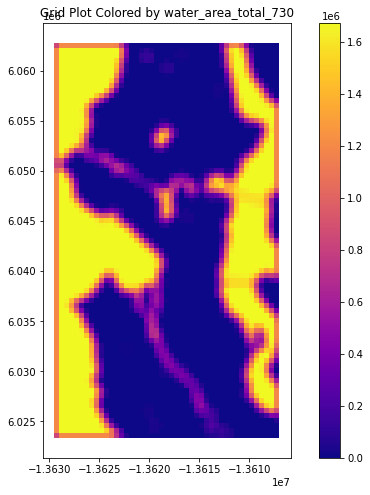

In [66]:
# Plot the GeoDataFrame and color by 'highway_length'
grid_gdf.plot(column='water_area_total_730', cmap='plasma', legend=True, figsize=(10, 8))

# Add title and show plot
plt.title('Grid Plot Colored by water_area_total_730')
plt.show()

In [67]:
grid_gdf.to_csv('grid_gdf_streets_buildingslanda_tc_lc_water.csv', index=False)

# Land Surface Temperature ('avg_lst_520')

In [68]:
lst= xr.open_rasterio('/Users/amandaworthy/Paper_3_GEE_files/Seattle_Landsat_2023.tif')

lst


/var/folders/_0/wy7tb6qj0kn08q2vk43vjwb40000gn/T/ipykernel_2036/3859463488.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  lst= xr.open_rasterio('/Users/amandaworthy/Paper_3_GEE_files/Seattle_Landsat_2023.tif')


<xarray.DataArray (band: 1, y: 1320, x: 1142)>
[1507440 values with dtype=float64]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 47.79 47.79 47.79 47.79 ... 47.43 47.43 47.43 47.43
  * x        (x) float64 -122.5 -122.5 -122.5 -122.5 ... -122.2 -122.2 -122.2
Attributes:
    transform:      (0.00026949458523585647, 0.0, -122.48340252760012, 0.0, -...
    crs:            +init=epsg:4326
    res:            (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('ST_B10',)
    AREA_OR_POINT:  Area

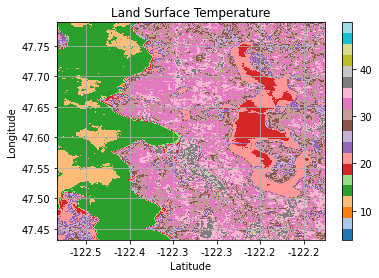

In [71]:
lst.plot(cmap='tab20')
plt.title('Land Surface Temperature')

plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# Add axis labels
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Optionally, customize other aspects of the plot
plt.grid(True)

# Show the plot
plt.show()

<AxesSubplot:>

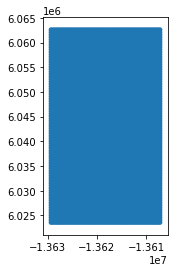

In [72]:
grid_gdf_520= buffers_dict[520]

grid_gdf_520 = grid_gdf_520.to_crs(epsg=3857)
grid_gdf = grid_gdf.to_crs(epsg=3857)

grid_gdf_520.plot()

In [73]:
import geopandas as gpd
import rioxarray
import numpy as np
import time

# Ensure the CRS of the GeoDataFrame matches the CRS of the raster
grid_gdf_520= grid_gdf_520.to_crs(lst.rio.crs)

# Function to calculate the average tree canopy coverage for each geometry
def calculate_average_lst(geometry, raster):
    try:
        # Clip the raster using the geometry
        clipped_raster = raster.rio.clip([geometry], grid_gdf_520.crs, drop=True)
        
        # Calculate the mean of the non-NaN values
        mean_lst = clipped_raster.mean().item()
        
        # Handle cases where the mean is NaN (e.g., no intersection)
        if np.isnan(mean_lst):
            return None  # or return 0 if you prefer to use 0 as a default value
        
        return mean_lst
    
    except Exception as e:
        # Handle any unexpected errors
        print(f"Error processing geometry: {e}")
        return None

# Start timing
start_time = time.time()

# Total number of rows
total_rows = len(grid_gdf_520)

# Create a list to store average canopy values
avg_lst_values = []

# Iterate through each geometry and calculate the average canopy
for i, geometry in enumerate(grid_gdf_520['geometry']):
    avg_lst = calculate_average_lst(geometry, lst)
    avg_lst_values.append(avg_lst)

# Assign the calculated values to the GeoDataFrame
grid_gdf['avg_lst_520'] = avg_lst_values

# End timing
end_time = time.time()
total_elapsed_time = end_time - start_time

# Print the total elapsed time
print(f"Total elapsed time for calculating average canopy coverage: {total_elapsed_time:.2f} seconds")

# Display the first few rows of the GeoDataFrame




Total elapsed time for calculating average canopy coverage: 93.20 seconds


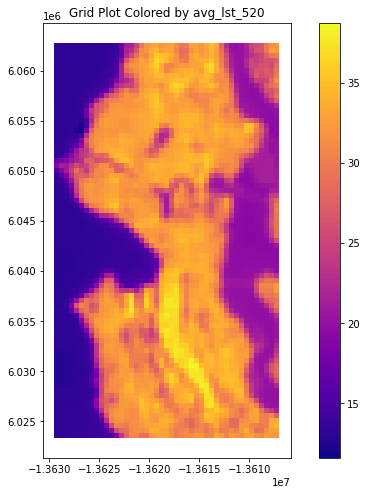

In [74]:
# Plot the GeoDataFrame and color by 'highway_length'
grid_gdf.plot(column='avg_lst_520', cmap='plasma', legend=True, figsize=(10, 8))

# Add title and show plot
plt.title('Grid Plot Colored by avg_lst_520')
plt.show()

In [76]:
grid_gdf = grid_gdf.rename(columns={'water_area_total_730': 'water_area_730'})

In [77]:
#grid_gdf.to_csv('grid_gdf_streets_buildingslanda_tc_lc_water_lst.csv', index=False)

In [ ]:
# add elevation 

In [78]:
grid_gdf.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
grid_gdf.head()